# Short-term electricity price prediction in the Spanish energy market

The dataset contains two distinct .csv files which contain information about the energy and weather patterns in spain for 2015-2019: 
> **`'weather_features.csv':`** Contains hourly information about the weather conditions (e.g. temperature, wind speed, humidity, rainfall, qualitative desctiption) of 5 major cities of Spain (Madrid, Barcelona, Valencia, Seville and Bilbao).

> **`'energy_dataset.csv':`** Contains hourly information about the generation of energy in Spain. In particular, there is info (in MW) about every type of energy which is used to generate energy (fossil gas, fossil hard coal and wind energy dominate the energy grid), as well as about the total load (energy demand) of the national grid and the price of energy (&euro;/MWh). 
_Note: Since the generation of each energy type is in MW and the time-series contains hourly info, the number of each cell represent MWh._

**The dataset can be found [HERE!](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)**

The information that we have about the weather of 5 major cities in Spain (highlighted by a red star on the map below) is probably more than enough for our analysis, since their geographic distribution covers most of the part of Spain's territory in a uniform manner. Moreover, it is useful to note that these 5 cities alone comprise approximately 1/3rd of the total population of Spain.

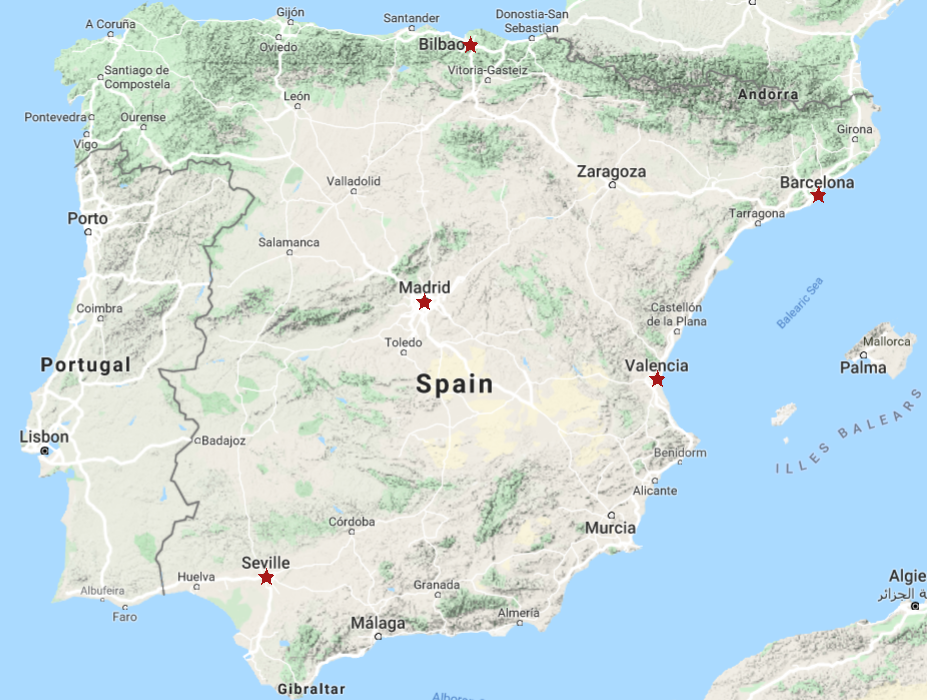

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import scipy.special as scsp
#import holidays
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from difflib import SequenceMatcher
from math import sqrt

%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
tf.random.set_seed(42)
np.random.seed(42)
tf.keras.backend.set_floatx('float32')

## 1. Exploration and cleaning

In [4]:
df_weather = pd.read_csv('weather_features.csv', parse_dates=['dt_iso'])
df_energy = pd.read_csv('energy_dataset.csv', parse_dates=['time'])

### 1.1. Energy Dataset

First, we will work on `energy_dataset.csv`, which we will hereby refer to as `df_energy`.

In [5]:
df_energy.tail()

time  generation biomass  \
35059  2018-12-31 19:00:00+01:00               297.0   
35060  2018-12-31 20:00:00+01:00               296.0   
35061  2018-12-31 21:00:00+01:00               292.0   
35062  2018-12-31 22:00:00+01:00               293.0   
35063  2018-12-31 23:00:00+01:00               290.0   

       generation fossil brown coal/lignite  \
35059                                   0.0   
35060                                   0.0   
35061                                   0.0   
35062                                   0.0   
35063                                   0.0   

       generation fossil coal-derived gas  generation fossil gas  \
35059                                 0.0                 7634.0   
35060                                 0.0                 7241.0   
35061                                 0.0                 7025.0   
35062                                 0.0                 6562.0   
35063                                 0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
35059                       2628.0                  178.0   
35060                       2566.0                  174.0   
35061                       2422.0                  168.0   
35062                       2293.0                  163.0   
35063                       2166.0                  163.0   

       generation fossil oil shale  generation fossil peat  \
35059                          0.0                     0.0   
35060                          0.0                     0.0   
35061                          0.0                     0.0   
35062                          0.0                     0.0   
35063                          0.0                     0.0   

       generation geothermal  ...  generation waste  generation wind offshore  \
35059                    0.0  ...             277.0                       0.0   
35060                    0.0  ...             280.0                       0.0   
35061                    0.0  ...             286.0                       0.0   
35062                    0.0  ...             287.0                       0.0   
35063                    0.0  ...             287.0                       0.0   

       generation wind onshore  forecast solar day ahead  \
35059                   3113.0                      96.0   
35060                   3288.0                      51.0   
35061                   3503.0                      36.0   
35062                   3586.0                      29.0   
35063                   3651.0                      26.0   

       forecast wind offshore eday ahead  forecast wind onshore day ahead  \
35059                                NaN                           3253.0   
35060                                NaN                           3353.0   
35061                                NaN                           3404.0   
35062                                NaN                           3273.0   
35063                                NaN                           3117.0   

       total load forecast  total load actual  price day ahead  price actual  
35059              30619.0            30653.0            68.85         77.02  
35060              29932.0            29735.0            68.40         76.16  
35061              27903.0            28071.0            66.88         74.30  
35062              25450.0            25801.0            63.93         69.89  
35063              24424.0            24455.0            64.27         69.88  

[5 rows x 29 columns]

In [6]:
df_energy.describe().round(2)

generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0               35046.00   
mean                                  0.0                5622.74   
std                                   0.0                2201.83   
min                                   0.0                   0.00   
25%                                   0.0                4126.00   
50%                                   0.0                4969.00   
75%                                   0.0                6429.00   
max                                   0.0               20034.00   

       generation fossil hard coal  generation fossil oil  \
count                     35046.00               35045.00   
mean                       4256.07                 298.32   
std                        1961.60                  52.52   
min                           0.00                   0.00   
25%                        2527.00                 263.00   
50%                        4474.00                 300.00   
75%                        5838.75                 330.00   
max                        8359.00                 449.00   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  ...  \
count                35046.0                                         0.0  ...   
mean                     0.0                                         NaN  ...   
std                      0.0                                         NaN  ...   
min                      0.0                                         NaN  ...   
25%                      0.0                                         NaN  ...   
50%                      0.0                                         NaN  ...   
75%                      0.0                                         NaN  ...   
max                      0.0                                         NaN  ...   

       generation waste  generation wind offshore  generation wind onshore  \
count          35045.00                   35046.0                 35046.00   
mean             269.45                       0.0                  5464.48   
std               50.20                       0.0                  3213.69   
min                0.00                       0.0                     0.00   
25%              240.00                       0.0                  2933.00   
50%              279.00                       0.0                  4849.00   
75%              310.00                       0.0                  7398.00   
max              357.00                       0.0                 17436.00   

       forecast solar day ahead  forecast wind offshore eday ahead  \
count                  35064.00                                0.0   
mean                    1439.07                                NaN   
std                     1677.70       

We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable.

In [7]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead'], 
                            axis=1)

In [8]:
df_energy.describe().round(2)

generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil gas  generation fossil hard coal  \
count               35046.00                     35046.00   
mean                 5622.74                      4256.07   
std                  2201.83                      1961.60   
min                     0.00                         0.00   
25%                  4126.00                      2527.00   
50%                  4969.00                      4474.00   
75%                  6429.00                      5838.75   
max                 20034.00                      8359.00   

       generation fossil oil  generation hydro pumped storage consumption  \
count               35045.00                                     35045.00   
mean                  298.32                                       475.58   
std                    52.52                                       792.41   
min                     0.00                                         0.00   
25%                   263.00                                         0.00   
50%                   300.00                                        68.00   
75%                   330.00                                       616.00   
max                   449.00                                      4523.00   

       generation hydro run-of-river and poundage  \
count                                    35045.00   
mean                                       972.12   
std                                        400.78   
min                                          0.00   
25%                                        637.00   
50%                                        906.00   
75%                                       1250.00   
max                                       2000.00   

       generation hydro water reservoir  generation nuclear  generation other  \
count                          35046.00            35047.00          35046.00   
mean                            2605.11             6263.91             60.23   
std                             1835.20              839.67             20.24   
min                                0.00                0.00              0.00   
25%                             1077.25             5760.00             53.00   
50%                             2164.00             6566.00             57.00   
75%                             3757.00             7025.00             80.00   
max                             9728.00             7117.00            106.00   

       generation other renewable  generation solar  generation waste  \
count                    35046.00          35046.00          35045.00   
mean                        85.64           1432.67            269.45   
std                         14.08           1680.12             50.20   
min                          0.00              0.00              0.00   
25%                         73.00             71.00            240.00   
50%                         88.00            616.00            279.00   
75%                         97.00           2578.00            310.00   
max                        119.00           5792.00            357.00   

       generation wind onshore  forecast solar day ahead  \
count                 35046.00                  35064.00   
mean                   5464.48                   1439.07   
std                    3213.69                   1677.70   
min                       0.00                      0

We can already see that the columns of `df_energy` have different numbers (count) of rows and thus, we expect some null data. Apart from that, we can see that the forecasted price ('price day ahead') is generally lower than the actual price ('price actual'). That means that the model used by the TSO tends to underestimate the energy price. 

In [9]:
# Print the type of each variable in the dataset

df_energy.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation solar                               float64
generation waste                               float64
generation wind onshore                        float64
forecast solar day ahead                       float64
forecast wind onshore day ahead                float64
total load forecast                            float64
total load

The 'time' column, which also functions as the index for the observations in a time-series, has not been parsed correctly and is recognized as an object.

In [10]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [11]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 20 columns):
generation biomass                             35045 non-null float64
generation fossil brown coal/lignite           35046 non-null float64
generation fossil gas                          35046 non-null float64
generation fossil hard coal                    35046 non-null float64
generation fossil oil                          35045 non-null float64
generation hydro pumped storage consumption    35045 non-null float64
generation hydro run-of-river and poundage     35045 non-null float64
generation hydro water reservoir               35046 non-null float64
generation nuclear                             35047 non-null float64
generation other                               35046 non-null float64
generation other renewable                     35046 non-null float64
generation solar                               35046 non-null float64
gene

In [12]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'.format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy (except first occurrence) based on all columns.'.format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy (except first occurrence) based on all columns.


As we can see, `df_energy` has no duplicate values. Nevertheless, it has some NaNs and thus, we have to investigate further. Since this is a time-series forecasting task, we cannot simply drop the rows with the missing values and it would be a better idea to fill the missing values using interpolation.

In [13]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0


Most null values can be found in the 'total load actual' column. Therefore, it is a good idea to visualize it and see what we can do. The good news is that there are no NaNs neither in the 'price day ahead' nor in the 'price actual' columns, which we will use as the target variable in order to train our model. The similar numbers in null values in the columns which have to do with the type of energy generation probably indicate that they will also appear in the same rows. Let us first define a plot function which we will then use so as to visualize the 'total load actual' column, as well as other columns.

In [14]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe and which
    constitutes one of its columns or it a custom pandas series created by the user.
    The user can define either the 'df' and the 'column' or the 'series' and additionally,
    can also define the 'label', the 'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

/home/dimitriosrou/anaconda3/envs/energy-prediction/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


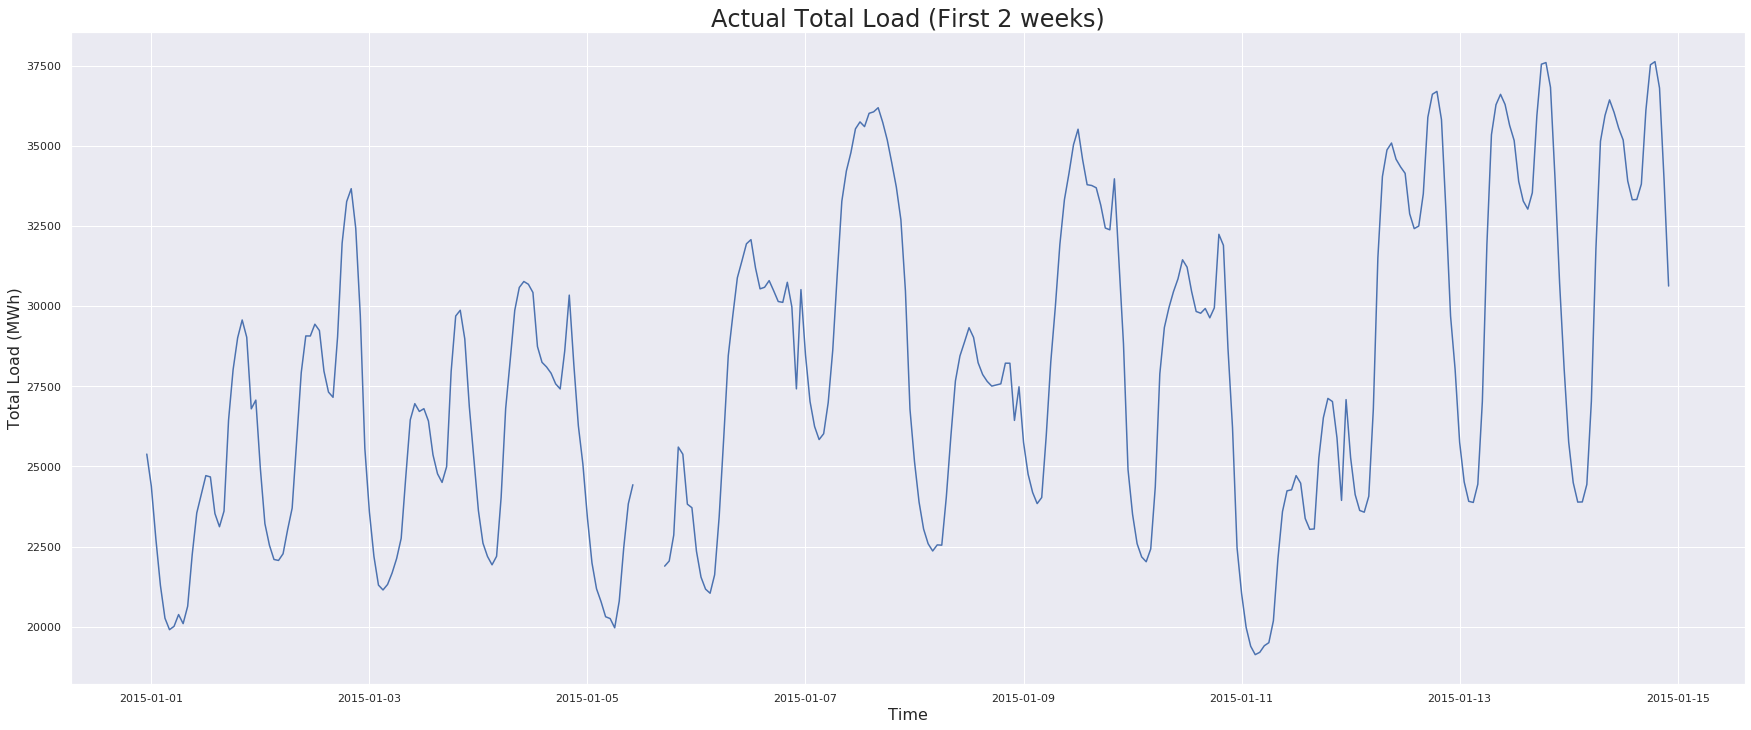

In [15]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks)', end=24*7*2)
plt.show()

After zooming into the first 2 weeks of the 'total load actual' column, we can already see that there are null values for a few hours. However, the number of the missing values and the behavior of the series indicate that an interpolation would fill the NaNs quite well. Let us further investigate if the null values coincide across the different columns. Since they are not so many, we can display all of them.

In [16]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)]

generation biomass  \
time                                            
2015-01-05 02:00:00+00:00                 NaN   
2015-01-05 11:00:00+00:00                 NaN   
2015-01-05 12:00:00+00:00                 NaN   
2015-01-05 13:00:00+00:00                 NaN   
2015-01-05 14:00:00+00:00                 NaN   
2015-01-05 15:00:00+00:00                 NaN   
2015-01-05 16:00:00+00:00                 NaN   
2015-01-19 18:00:00+00:00                 NaN   
2015-01-19 19:00:00+00:00                 NaN   
2015-01-27 18:00:00+00:00                 NaN   
2015-01-28 12:00:00+00:00                 NaN   
2015-02-01 06:00:00+00:00               449.0   
2015-02-01 07:00:00+00:00               453.0   
2015-02-01 08:00:00+00:00               452.0   
2015-02-01 11:00:00+00:00               405.0   
2015-02-01 12:00:00+00:00               402.0   
2015-02-01 13:00:00+00:00               400.0   
2015-02-01 14:00:00+00:00               393.0   
2015-02-01 15:00:00+00:00               413.0   
2015-02-01 16:00:00+00:00               465.0   
2015-02-01 17:00:00+00:00               482.0   
2015-02-01 18:00:00+00:00               474.0   
2015-04-05 01:00:00+00:00               371.0   
2015-04-16 07:00:00+00:00                 NaN   
2015-04-20 06:00:00+00:00               424.0   
2015-04-23 19:00:00+00:00                 NaN   
2015-05-02 08:00:00+00:00               497.0   
2015-05-29 01:00:00+00:00               569.0   
2015-06-15 07:00:00+00:00                 NaN   
2015-10-02 06:00:00+00:00               483.0   
2015-10-02 09:00:00+00:00                 NaN   
2015-12-02 08:00:00+00:00                 NaN   
2016-04-13 03:00:00+00:00               220.0   
2016-04-25 03:00:00+00:00               190.0   
2016-04-25 05:00:00+00:00               206.0   
2016-05-10 21:00:00+00:00               348.0   
2016-06-11 23:00:00+00:00               356.0   
2016-07-09 20:00:00+00:00                 NaN   
2016-07-11 22:00:00+00:00               346.0   
2016-09-28 07:00:00+00:00               347.0   
2016-10-27 21:00:00+00:00               351.0   
2016-11-23 03:00:00+00:00                 NaN   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-05 02:00:00+00:00                                   NaN   
2015-01-05 11:00:00+00:00                                   NaN   
2015-01-05 12:00:00+00:00                                   NaN   
2015-01-05 13:00:00+00:00                                   NaN   
2015-01-05 14:00:00+00:00                                   NaN   
2015-01-05 15:00:00+00:00                                   NaN   
2015-01-05 16:00:00+00:00                                   NaN   
2015-01-19 18:00:00+00:00                                   NaN   
2015-01-19 19:00:00+00:00                                   NaN   
2015-01-27 18:00:00+00:00                                   NaN   
2015-01-28 12:00:00+00:00                                   NaN   
2015-02-01 06:00:00+00:00                                 312.0   
2015-02-01 07:00:00+00:00                                 312.0   
2015-02-01 08:00:00+00:00                                 302.0   
2015-02-01 11:00:00+00:00                                 317.0   
2015-02-01 12:00:00+00:00                                 317.0   
2015-02-01 13:00:00+00:00                                 317.0   
2015-02-01 14:00:00+00:00                                 321.0   
2015-02-01 15:00:00+00:00                                 325.0   
2015-02-01 16:00:00+00:00                                 321.0   
2015-02-01 17:00:00+00:00                                 326.0   
2015-02-01 18:00:00+00:00                                 326.0   
2015-04-05 01:00:00+00:00                                   0.0   

We can confirm that the null values in the columns which have to do with the type of energy generation mostly coincide. The null values in 'actual total load' also coincide with the aforementioned columns, but also appear in other rows as well.

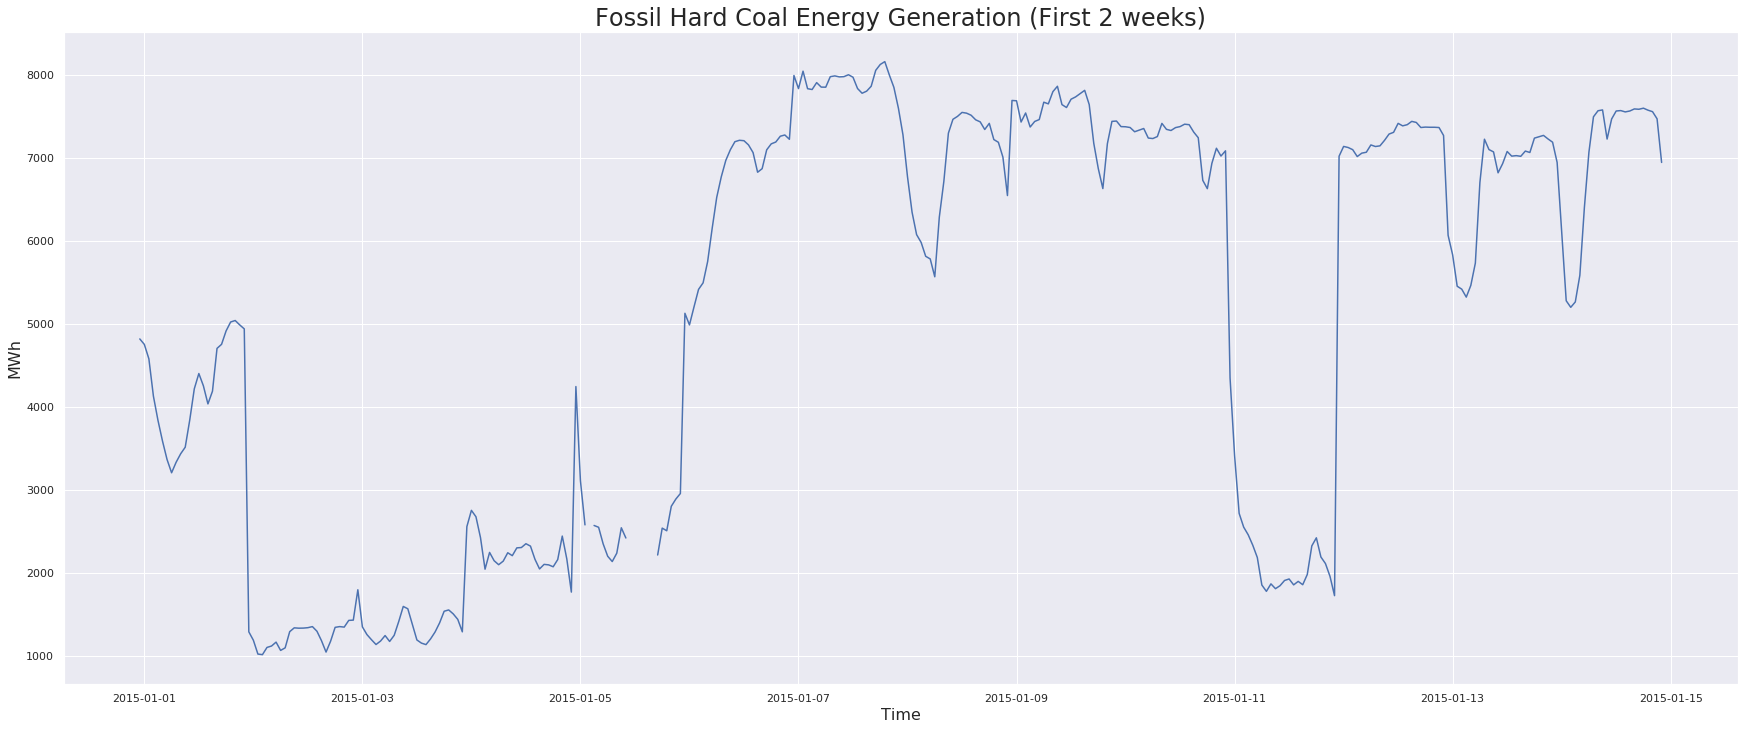

In [17]:
# Zoom into the null values of 'generation fossil hard coal'

ax = plot_series(df=df_energy, column='generation fossil hard coal', ylabel='MWh',
                 title='Fossil Hard Coal Energy Generation (First 2 weeks)', end=24*7*2)
plt.show()

In order to handle the null values in `df_energy`, we will use a linear interpolation with a forward direction. Perhaps other kinds of interpolation would be better; nevertheless, we prefer to use the simplest model possible. Only a small part of our input data will be noisy and it will not affect performance noticeably.

In [18]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

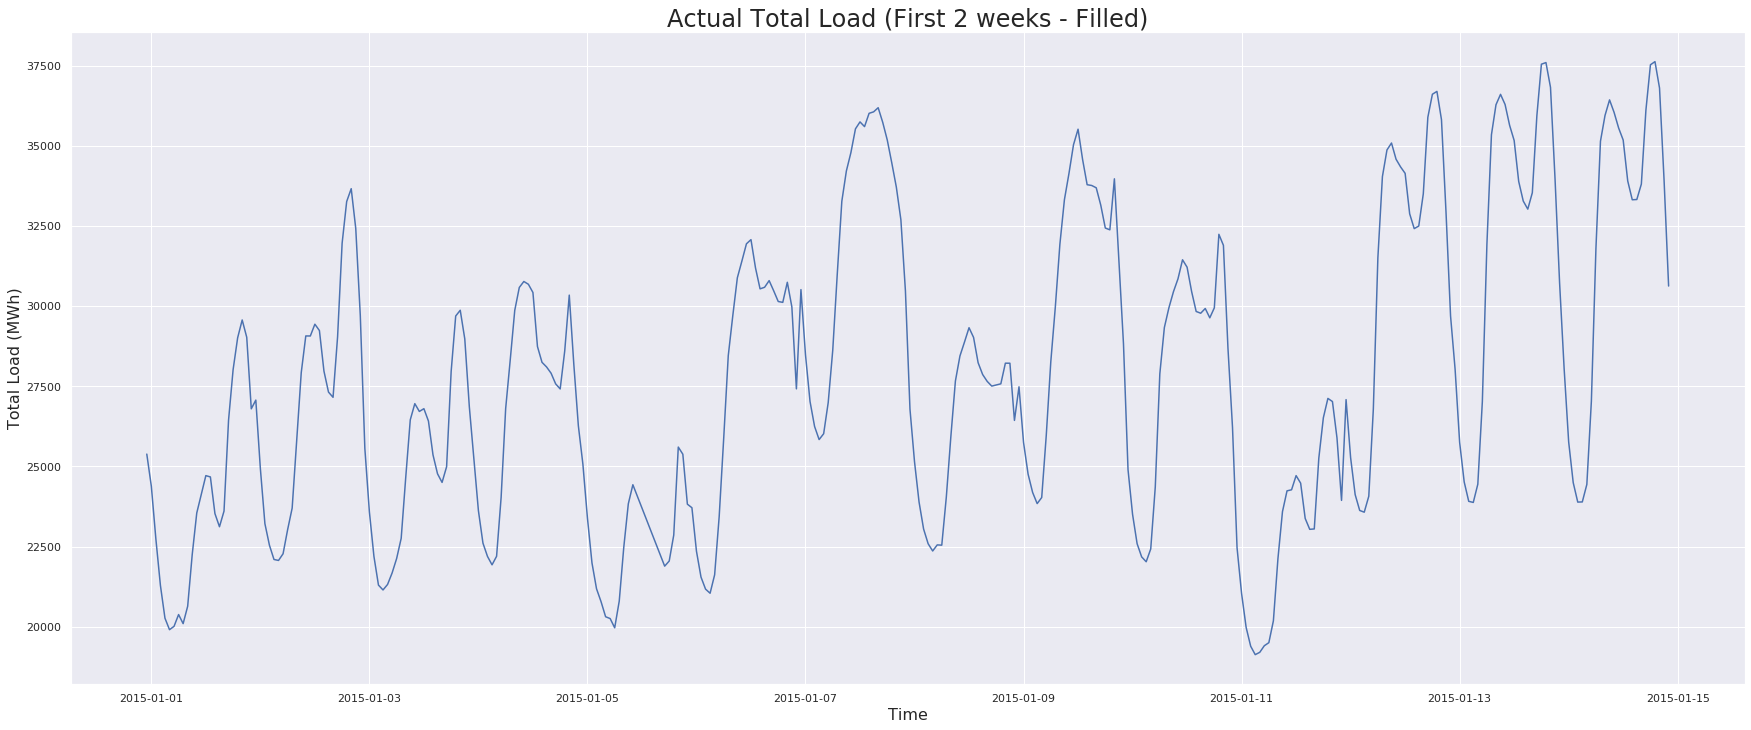

In [19]:
# Zoom again into the plot of the filled hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Filled)', end=24*7*2)
plt.show()

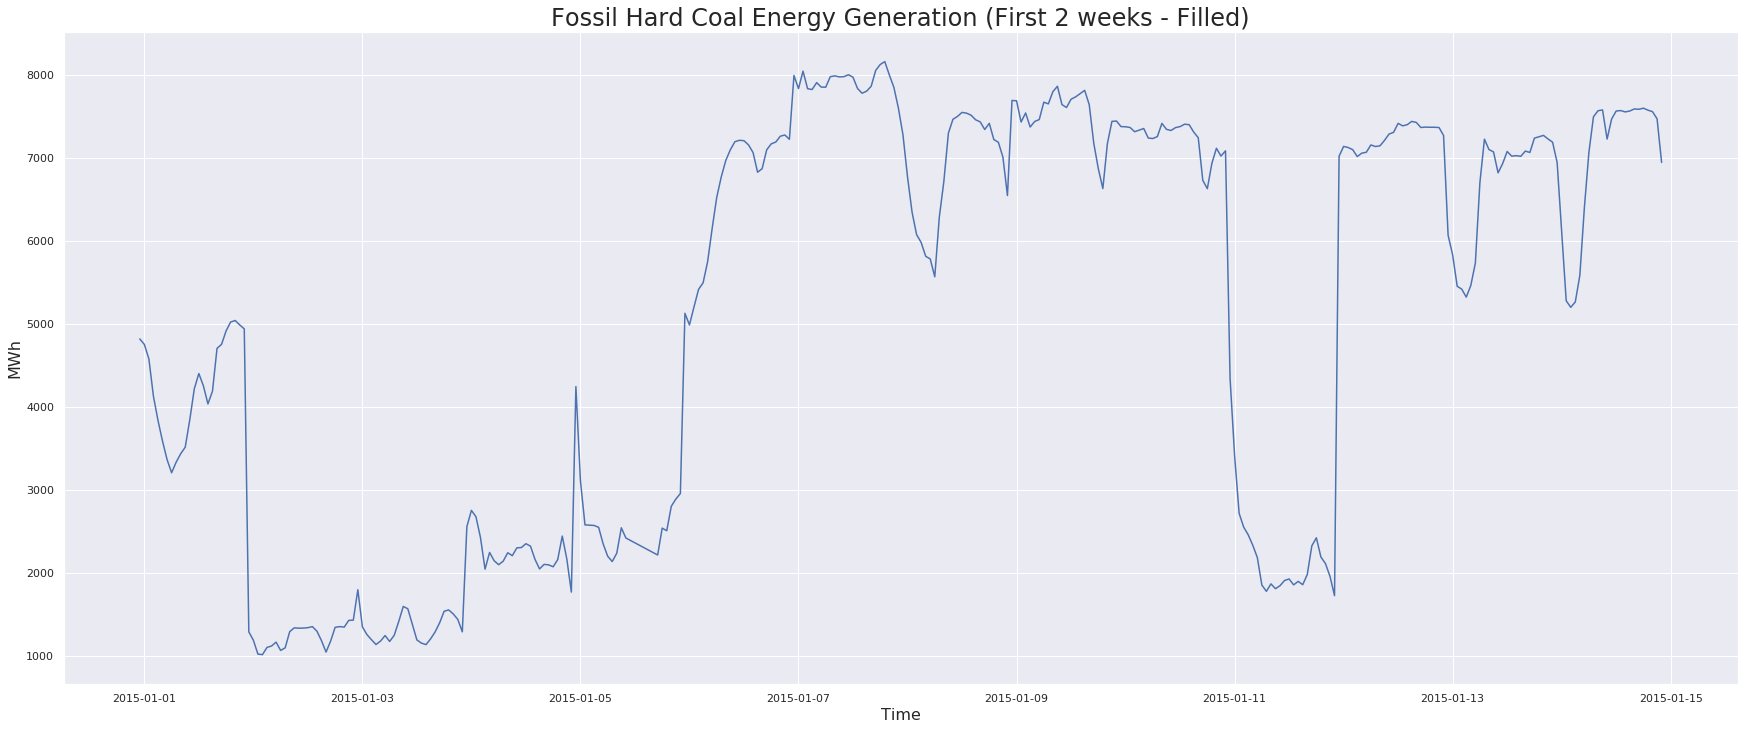

In [20]:
# Zoom again into the plot of the filled hourly 'generation fossil hard coal'

ax = plot_series(df=df_energy, column='generation fossil hard coal', ylabel='MWh',
                 title='Fossil Hard Coal Energy Generation (First 2 weeks - Filled)', end=24*7*2)
plt.show()

In [21]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
forecast solar day ahead                       34525
forecast wind onshore day ahead                35064
total load forecast                            35064
total load actual                              35064
price day ahe

It look like `df_energy` has been cleaned successfully and is ready for further use as input into our model. The 1-4 zeroes in the columns which have to do with energy generation by type should not concern us very much. The 'generation hydro pumped storage consumption' may look suspicious, but we should have in mind that this type of energy is only used for load balancing, being consumed when in peak energy demands. The column which would need some deeper examination is 'forecast solar day ahead'. However, we will most likely not need it at all in the training process of our model (as well as 'forecast wind onshore day ahead').

### 1.2. Weather features dataset

Now, we move on to work with `weather_features.csv`, which we will refer to as `df_weather` from now on.

In [22]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [23]:
df_weather.describe().round(2)

temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00   178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09     1069.26      68.42        2.47   
std         8.03       7.96       8.61     5969.63      21.90        2.10   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.48     284.65     1013.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.73     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  weather_id  
count  178396.00  178396.00  178396.00  178396.00   178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07      759.83  
std       116.61       0.40       0.01       0.22       30.77      108.73  
min         0.00       0.00       0.00       0.00        0.00      200.00  
25%        55.00       0.00       0.00       0.00        0.00      800.00  
50%       177.00       0.00       0.00       0.00       20.00      800.00  
75%       270.00       0.00       0.00       0.00       40.00      801.00  
max       360.00      12.00       2.32      21.50      100.00      804.00

Here, we can see that all columns of `df_weather` have the same number of rows; we still have to check what is the case for each city individually, though. We should note that the temperatures are in Kelvin. Below, we can see the formulas to convert the temperature into Celsius and Fahrenheit, just in case we want to get a better sense of the temperature values in the dataset. 

$$T_{Celsius} = {T_{Kelvin} + {273.15}}$$ 

$$T_{Fahrenheit} = {T_{Kelvin} * {9 \over 5} - {459.67}}$$ 

But, the most important thing to notice is that there are some **problems** and **outliers**. In particular:
- There is at least one outlier in the 'pressure' column as the maximum value is 1,008,371 hPa or approximately 100 MPa, which is roughly the pressure at the bottom of Mariana Trench about 11 km below ocean surface [[1]](#ref1). This cannot be the case here.
- There is at least one outlier in the 'wind_speed' column as the maximum value is 133 m/s. This measurement is close to the fastest wind speed ever recorded on Earth, caused by the 1999 Bridge Creek–Moore tornado [[2]](#ref2), a F5 (the largest intensity of the Fujita scale) tornado [[3]](#ref3). A tornado of such intensity has not been recorded in Spain [[4]](#ref4) and hopefully will not happen in the future as well. 
- The 'rain_3h' column is supposed to provide information about the precipitation (i.e. rain) of the last 3 hours in mm. Since the 'rain_1h' column is supposed to provide the same information but about just the last hour, it would be logical to assume that its mean would be less than that of 'rain_3h'. However, this is not the case in the statistical description above. So, it would be a good idea to further examine those columns.

In [24]:
# Print the type of each variable in df_weather

df_weather.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

We have to change the type of some of the columns, so that all of them are float64. We also have to parse 'dt_iso' correctly and actually rename it as 'time' so that it matches with the index of `df_energy`.

In [25]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [26]:
# Convert columns with int64 type values to float64 type

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [27]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [28]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 16 columns):
city_name              178396 non-null object
temp                   178396 non-null float64
temp_min               178396 non-null float64
temp_max               178396 non-null float64
pressure               178396 non-null float64
humidity               178396 non-null float64
wind_speed             178396 non-null float64
wind_deg               178396 non-null float64
rain_1h                178396 non-null float64
rain_3h                178396 non-null float64
snow_3h                178396 non-null float64
clouds_all             178396 non-null float64
weather_id             178396 non-null float64
weather_main           178396 non-null object
weather_description    178396 non-null object
weather_icon           178396 non-null object
dtypes: float64(12), object(4)
memory usage: 23.1+ MB


We have to split the `df_weather` dataset into 5 datasets, one for each different city (Madrid, Barcelona, Bilbao, Seville and Valencia). But first, let's see the average values for each column, grouped by each city (note that the 'weather_id' average has no meaning whatsoever).

In [29]:
# Display average weather features grouped by each city

mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.848248  288.594704  291.021987  1284.010486  73.994221   
Bilbao      286.378489  284.916661  288.036687  1017.567439  79.089455   
Madrid      288.061071  286.824877  289.155600  1011.838448  59.776932   
Seville     293.105431  291.184103  295.962431  1018.504711  64.140732   
Valencia    290.780780  290.222277  291.355025  1015.973794  65.145113   

            wind_speed    wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  \
city_name                                                                      
 Barcelona    2.786588  187.188043  0.117079  0.000327  0.000000   23.229648   
Bilbao        1.957470  159.883536  0.123493  0.001034  0.023455   43.960697   
Madrid        2.441696  173.293159  0.055083  0.000129  0.000029   22.397028   
Seville       2.483787  151.757179  0.045392  0.000180  0.000000   14.748770   
Valencia      2.692815  160.753820  0.035924  0.000226  0.000154   20.820999   

            weather_id  
city_name               
 Barcelona  760.917465  
Bilbao      723.943228  
Madrid      762.260264  
Seville     771.409849  
Valencia    781.228283

In [30]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'.format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather except first occurrence based on all columns.'.format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather except first occurrence based on all columns.


It seems that `df_weather` has a lot of *duplicate values*. However, **the method above may also show us rows which have the exame same values**. This is not what we are looking for. What we want to ensure, is that **there are no duplicate index rows**, i.e. that we do not have multiple rows **for the exact same hour**. Of course, we also have to make sure that these duplicates concern **each individual city**. Since, `df_weather` contains information about 5 different cities, it is very useful to display the number of observations for each one and compare it with the size of `df_energy`.

In [31]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'.format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


As we can see, the two dataframes (`df_energy` and `df_weather`) cannot be merged yet. There are many duplicates for every city in `df_weather` and we should drop them and see if their number of rows match. We do this by resetting the index, keeping only the **first rows** which have the same 'time' and 'city_name' values and then setting again 'time' as the index. For further research on the dataset, let us also create a second dataframe, `df_weather_2` in which we do the same procedure, but keep only the **last rows** which have the same 'time' and 'city_name'.

In [32]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [33]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'.format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


The column 'weather_icon' is irrelevant for our analysis, so we will drop it. Furthermore, the columns 'weather_main' and 'weather_description' contain approximately the same information as the column 'weather_id'; the information concerns a qualitative description of the weather at the given hour. So, we will work with only one of them. However, in order to make a choice, we have to check the **unique values** as well as the **consistency** of each column. 

In [34]:
# Display all the unique values in the column 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [35]:
# Display all the unique values in the column 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [36]:
# Display all the unique values in the column 'weather_id'

weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

We can see that in terms of qualitative description, the 'weather_main' column seems to contain the less detailed -or "poorest"- information, while 'weather_id' and 'weather_description' have more complex information and approximately the same number of unique values.

Nevertheless, it is also useful to check the consistency of the information in each column. Since our dataset contained duplicate rows and we utilized two different methods for cleaning it, a very good way to check the consistency of the data in these three columns would be to compare the two cleaned dataframes, `df_weather` and `df_weather_2`. In order to do this, we employ the R² ("R-squared" or "coefficient of determination") metric, after encoding 'weather_description' and 'weather_main' from strings to numerical labels.

In [37]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [38]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


It seems that we have found incosistencies in our dataset. In particular, all three of the columns which contain qualitative info for the condition of the weather seem to contain a large part of the duplicates that we found earlier in `df_weather`. From the above R-squared scores, it seems that keeping and one-hot encoding 'weather_description' or 'weather_main' is the best idea to get the most out of information in the dataset. Note that **the R² values of these two are not comparable** because we have first encoded them; in order to actually calculate the similarity between two strings, we need to employ a different metric such as the *Levenshtein distance*, i.e. the number of edits required to transform string A to string B. In this case, even this metric would not be enough in order to make 'weather_main' and 'weather_description' comparable as the former contains only single words while the latter large phrases which describe the weather.

In [39]:
# Drop columns with qualitative weather information except for 'weather_description'

df_weather = df_weather.drop(['weather_main', 'weather_id', 'weather_description', 'weather_icon'], axis=1)

We have to emphasize that the method we employed above in order to check the consistency of our dataset **is not 100% accurate**. This is because it compares two dataframes from which we have cleaned the duplicates in **only two ways exclusively**; keeping the first rows and keeping the last rows of the duplicates. Nevertheless, it gives good results and can be used to check the values of the other columns as well. We should not that since we removed the duplicates based on all the columns except 'time' and 'city_name', there is no point in checking the latter.

In [40]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0


The above confirms our intuition that 'weather_description', 'weather_main' and 'weather_id' are the sole culprits for the duplicates in `df_weather` and although we are not absolutely certain for this (for the reasons we described above), it is more than enough to reaffirm the validity and consistency of the rest of the columns in `df_weather` which contain numerical values.

In [41]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'], keep='first').sum()
print('There are {} duplicate rows in df_weather except first occurrence ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather except first occurrence based on all columns except "time" and "city_name".


Before proceeding to the next step, i.e. merging `df_energy` and `df_weather`, we also want to treat the outliers which we found earlier in 'pressure' and 'wind_speed'. We will visualize the outliers in these columns using boxplot, change their values to NaNs and then use a linear interpolation in order to replace their values.

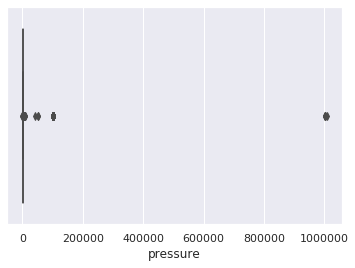

In [42]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])

Even a pressure of approximately 100,000 HPa or 10 MPa, which is clearly visible in the above figure, corresponds to a quantity greater than the atmospheric pressure of Venus [[1]](#ref1). In order to be sure, we will set as **NaN** every value in the 'pressure' column which is **higher than 1051 hPa**, which is just above the highest air pressure ever recorded in the Iberian peninsula [[5]](#ref5). While outliers on the low side are not visible in the boxplot above, it is a good idea to also replace the values which are **lower than 931 hPa**, i.e. the lowest air pressure ever recorded in the Iberian peninsula [[5]](#ref5).

In [43]:
# Replace outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

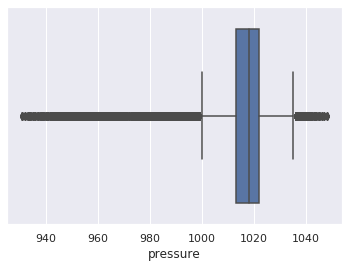

In [44]:
# Check for outliers in 'pressure' column again

sns.boxplot(x=df_weather['pressure'])

Things look a lot better regarding atmospheric pressure ('pressure') as the column has been cleaned of extreme-case outliers. What about 'wind_speed' however?

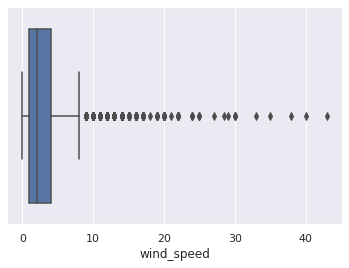

In [57]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

Here, we will follow a conservative approach as above. We will set as **NaNs** the values in 'wind_speed' which are **higher than 50 m/s**, which is the highest bound (112 mph) of the wind speed estimate of a F1 (Fujita scale) tornado [[3]](#ref3), having in mind that the last F1 tornado in Spain was Gandia tornado, which was recorded on 28th September 2012 [[4]](#ref4), i.e. roughly 2 years before the starting point of our available data.

In [46]:
# Replace outliers in 'wind_speed' with NaNs

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

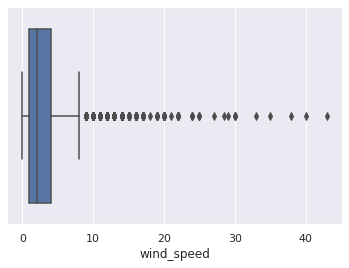

In [56]:
# Check for outliers in 'wind_speed' column again

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [48]:
df_weather.columns

Index(['city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all'],
      dtype='object')

In [49]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [50]:
df_weather.columns

Index(['city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all'],
      dtype='object')

Everything looks nice and clean and `df_weather` is also ready for use as input to our model. We also have to plot the 'rain_1h' and 'rain_3h' columns, as we have indicated that at least one of them (probably 'rain_3h') is quite problematic. Nevertheless, we will do so after we merge the two datasets.

## 2. Merging the two datasets

In [58]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [59]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp_Barcelona', 'temp_min_Barcelona',
       'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona',
       'wind_speed_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona',
       'rain_3h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_

In [60]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'.format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy except first occurrence based on all columns.'.format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy except first occurrence based on all columns.


In [61]:
# Interpolate NaNs and drop duplicates

df_final.interpolate(limit_direction='forward', inplace=True, axis=0)
df_final = df_final.drop_duplicates()

In [62]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'.format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy except first occurrence based on all columns.'.format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy except first occurrence based on all columns.


## 3. Visualizations, tests and insights

Before anything else, we will check the 'rain_1h' and 'rain_3h' columns for a specific city.

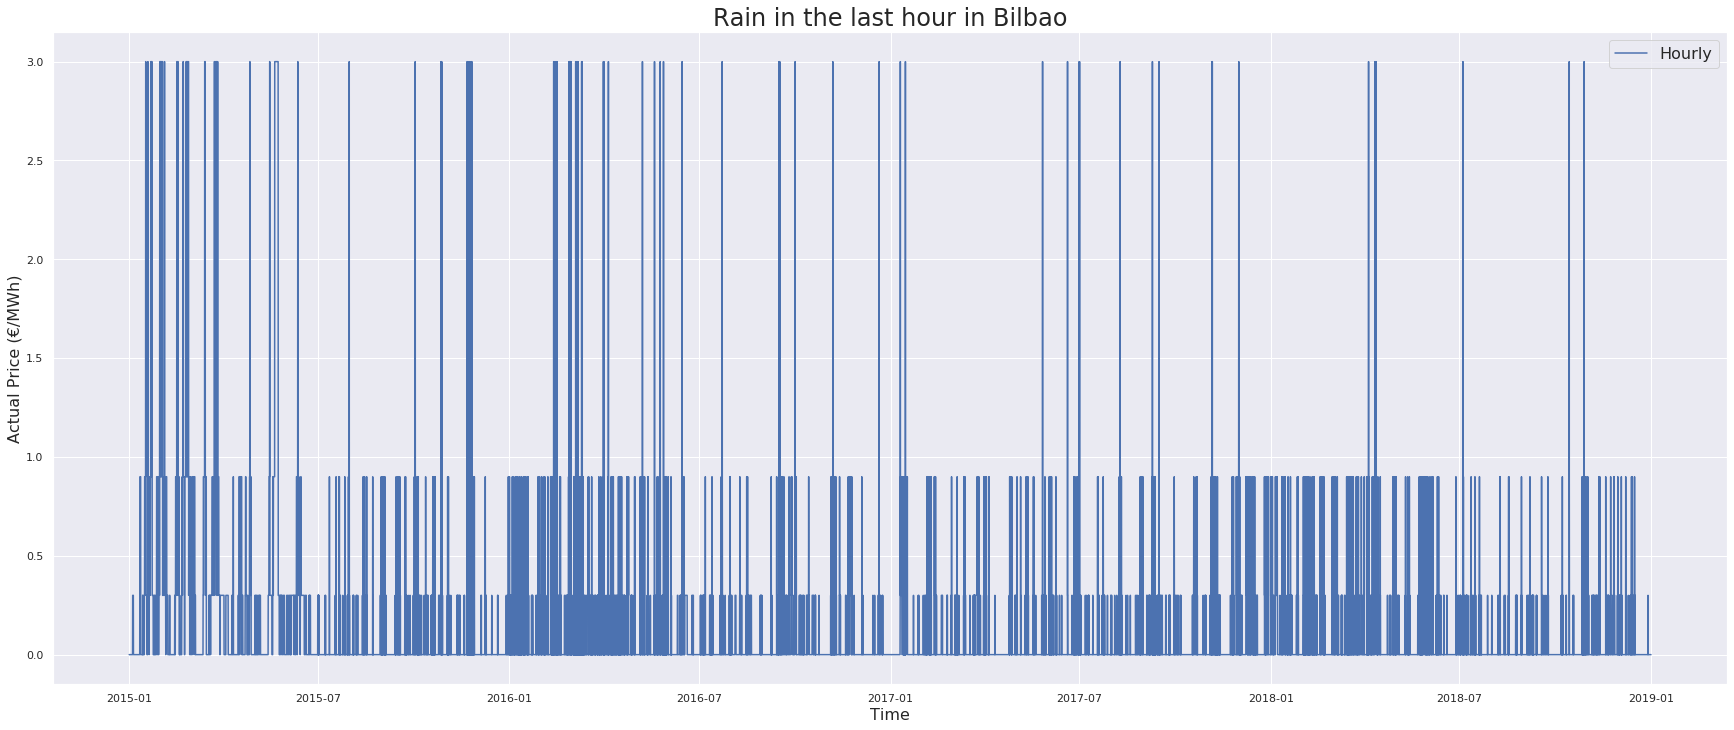

In [63]:
ax = plot_series(df_final, 'rain_1h_Bilbao', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Bilbao')
plt.show()

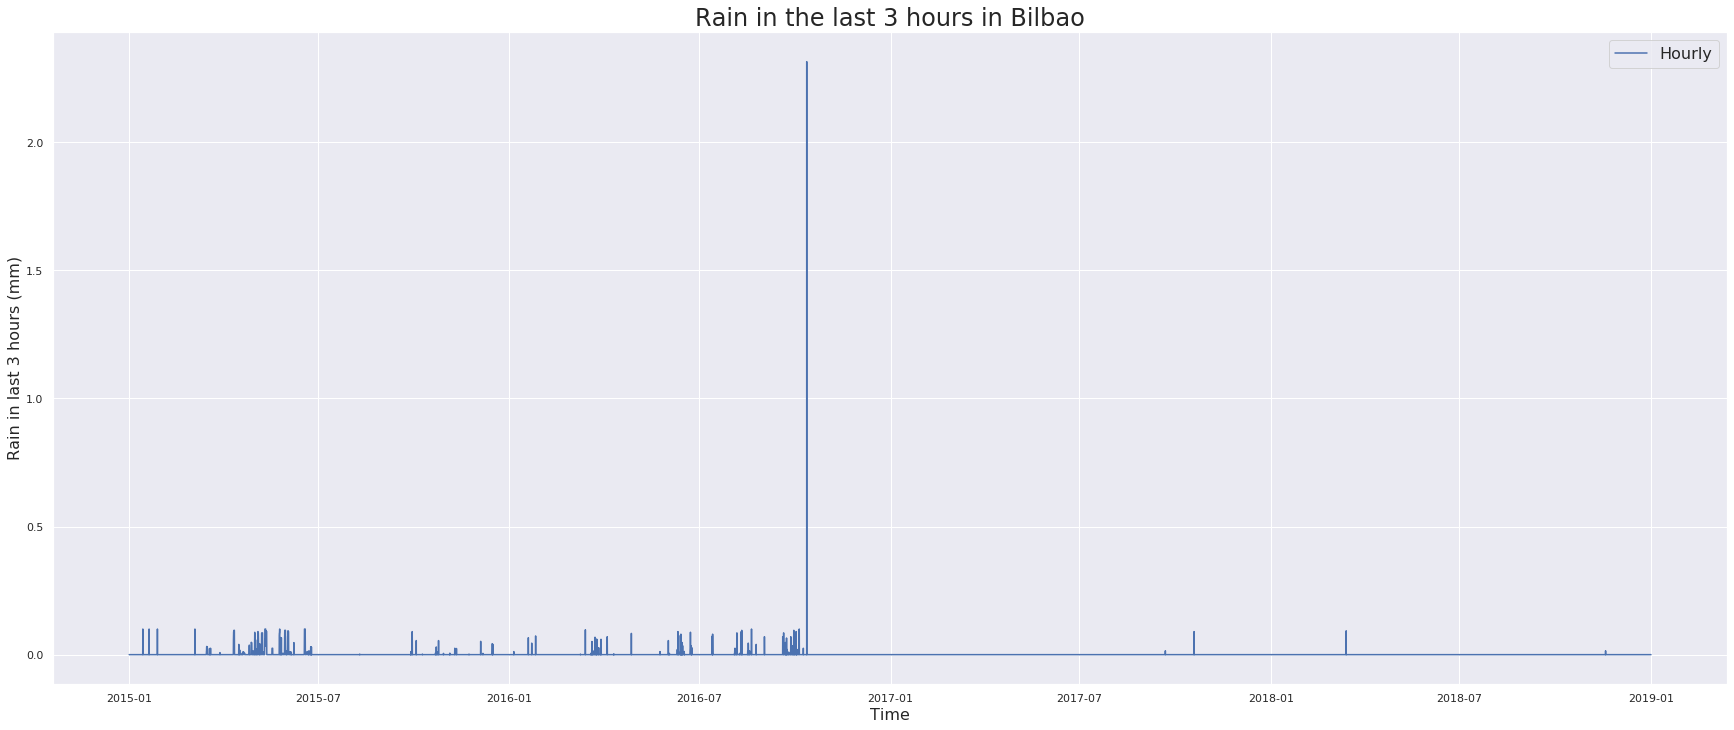

In [64]:
ax = plot_series(df_final, 'rain_3h_Bilbao', label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

From the two above figures, we can conclude that 'rain_3h' is an unreliable feature which will drop from the dataset.

In [65]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

The greatest characteristic of this dataset is that it also contains the forecasts for total load and price made by the TSO (Transmission Service Operator) "Red Electrica de Espana". Before computing the accuracy of its forecasts, it would be a good idea to visualize errors between the actual and the forecasted quantities in a standardized manner, i.e. looking at how many standard deviations (of the actual quantities) they differ.

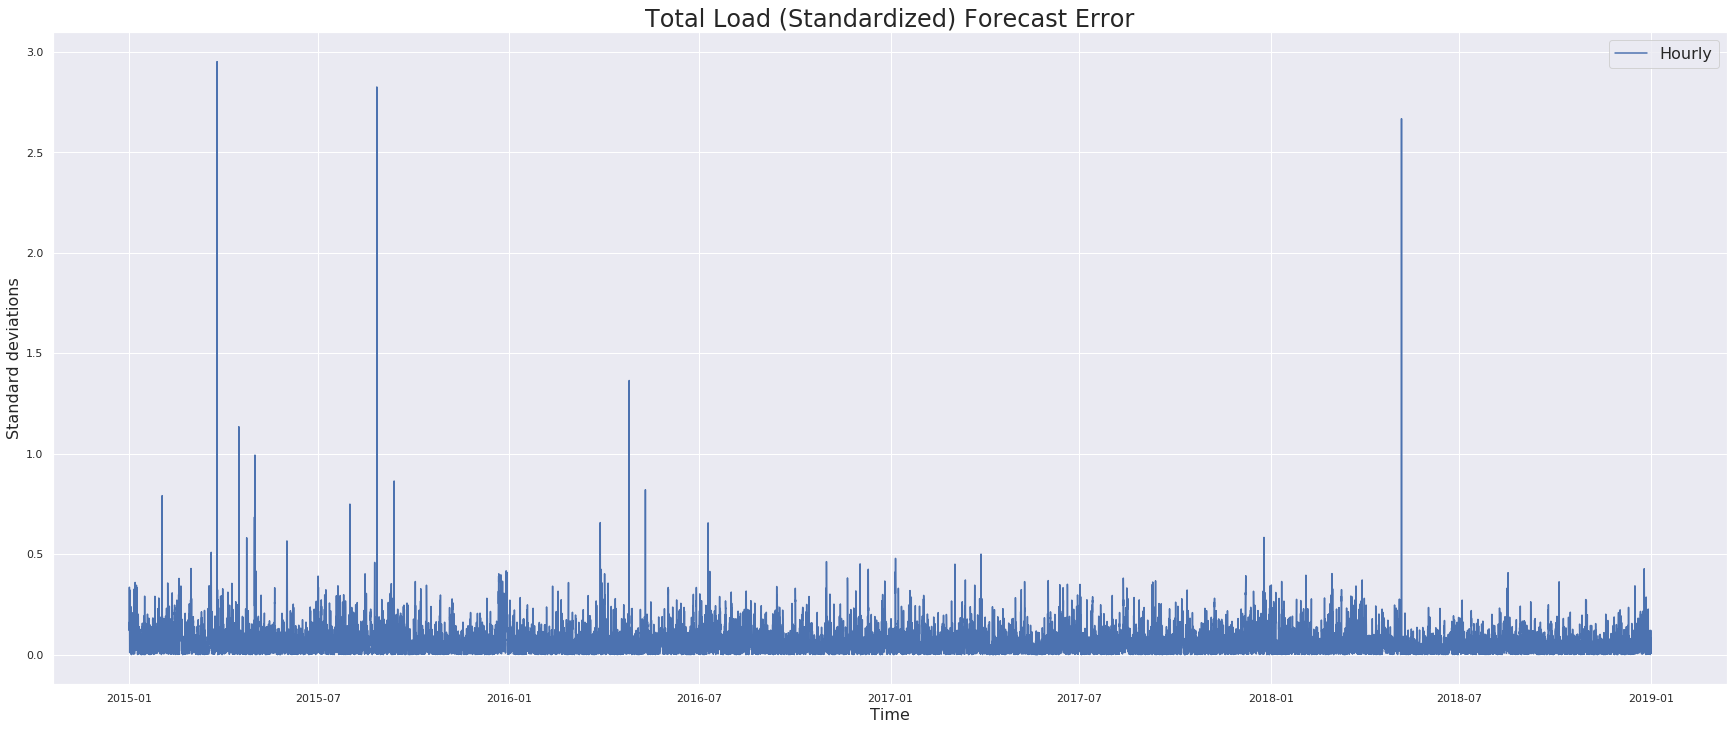

In [66]:
# Plot the standardized absolute hourly error between the actual total load and the forecasted total load

error_load = abs(df_energy['total load actual'] - df_energy['total load forecast'])
standardized_error_load = error_load / (df_energy['total load actual'].std())
ax = plot_series(series=standardized_error_load, label='Hourly', 
            ylabel='Standard deviations', title='Total Load (Standardized) Forecast Error')
plt.show()

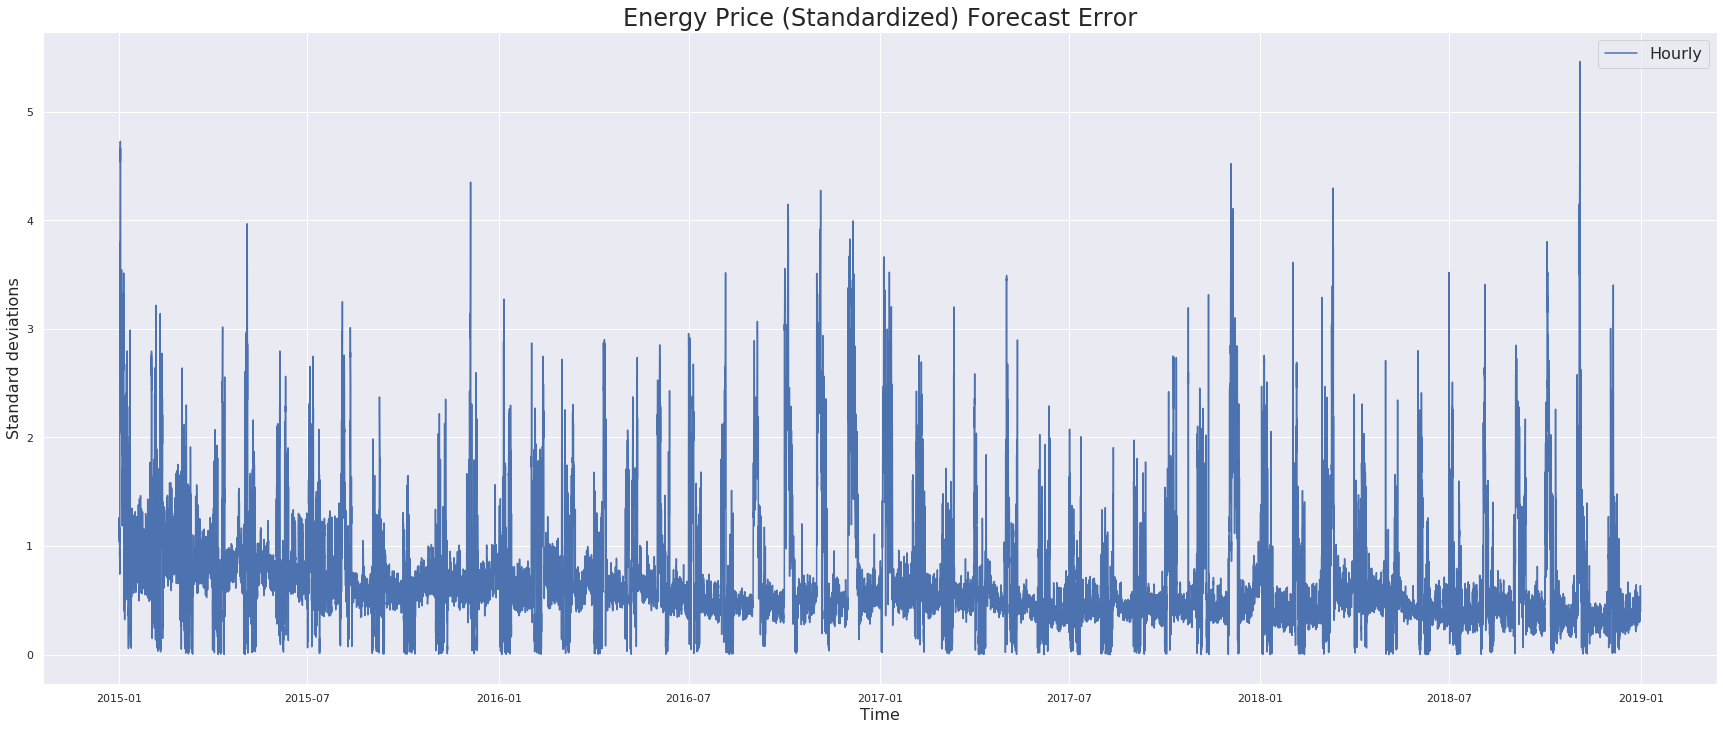

In [67]:
# Plot the standardized absolute hourly error between the actual price and the forecasted price

error_price = abs(df_energy['price actual'] - df_energy['price day ahead'])
standardized_error_price = error_price / (df_energy['price actual'].std())
ax = plot_series(series=standardized_error_price, label='Hourly', 
            ylabel='Standard deviations', title='Energy Price (Standardized) Forecast Error')
plt.show()

We can clearly see some patterns in the errors of the TSO's predictions:
- Regarding the **total load**, the predictions seem very reliable; virtually every prediction is closer than 0.5 standard deviations to the actual one. There are only a few outliers that need to be further investigated.


- Regarding the **energy price**, the errors of the predictions seem to exhibit patterns; in particular, the patterns appear to have periodicity (!) which would probably imply a periodically corrected (or self-correcting) algorithm. However, it is also clear that there is a lot more difficulty in predicting the energy price, since errors larger than 2 standard deviations are pretty common!

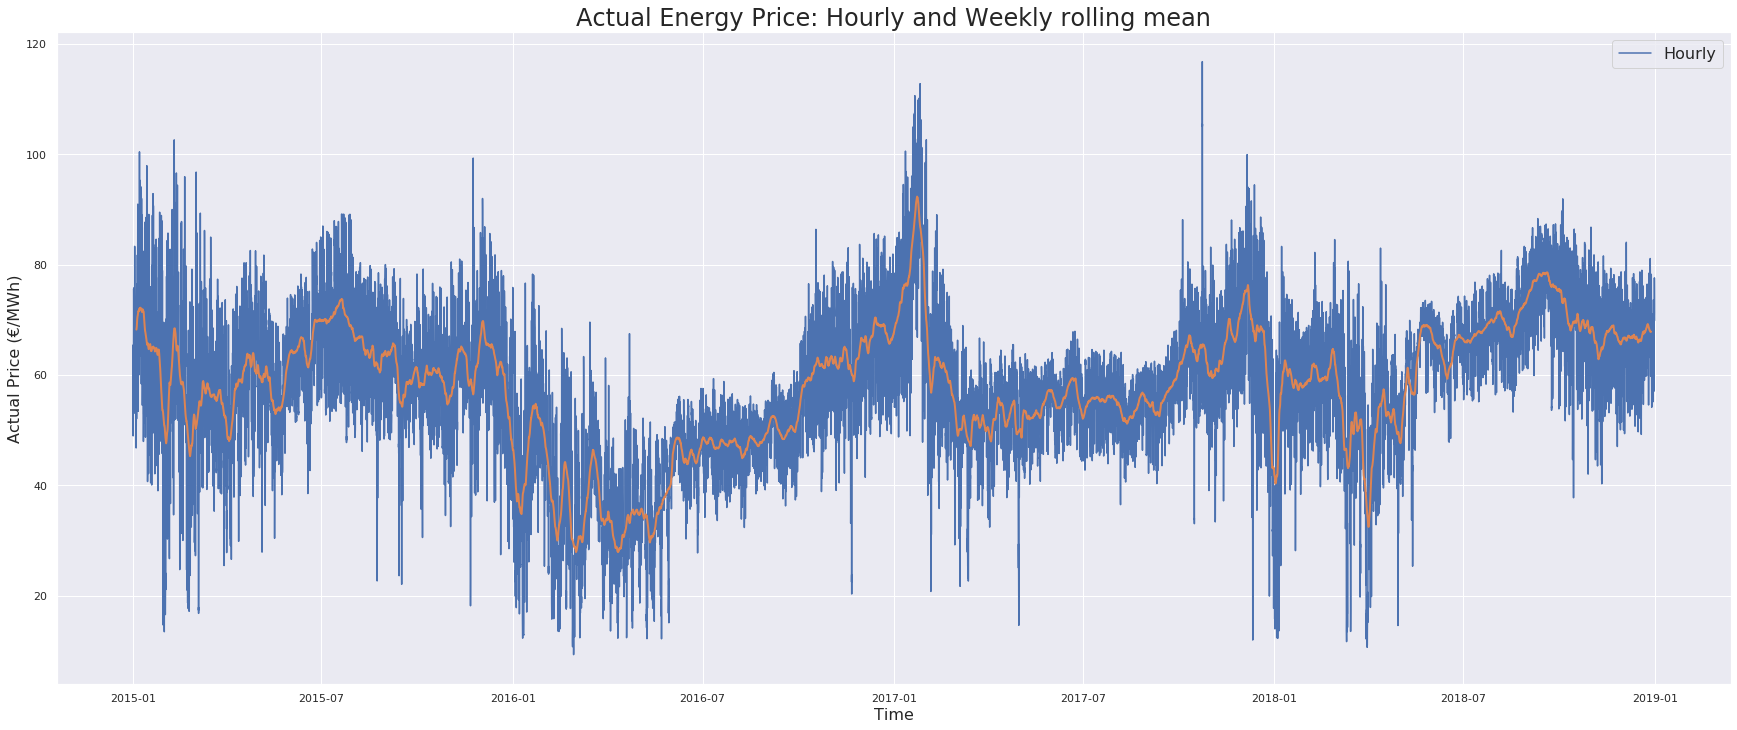

In [68]:
# Plot the hourly (actual) energy price, along with the weekly rolling mean

rolling = df_energy['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_energy, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Energy Price: Hourly and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

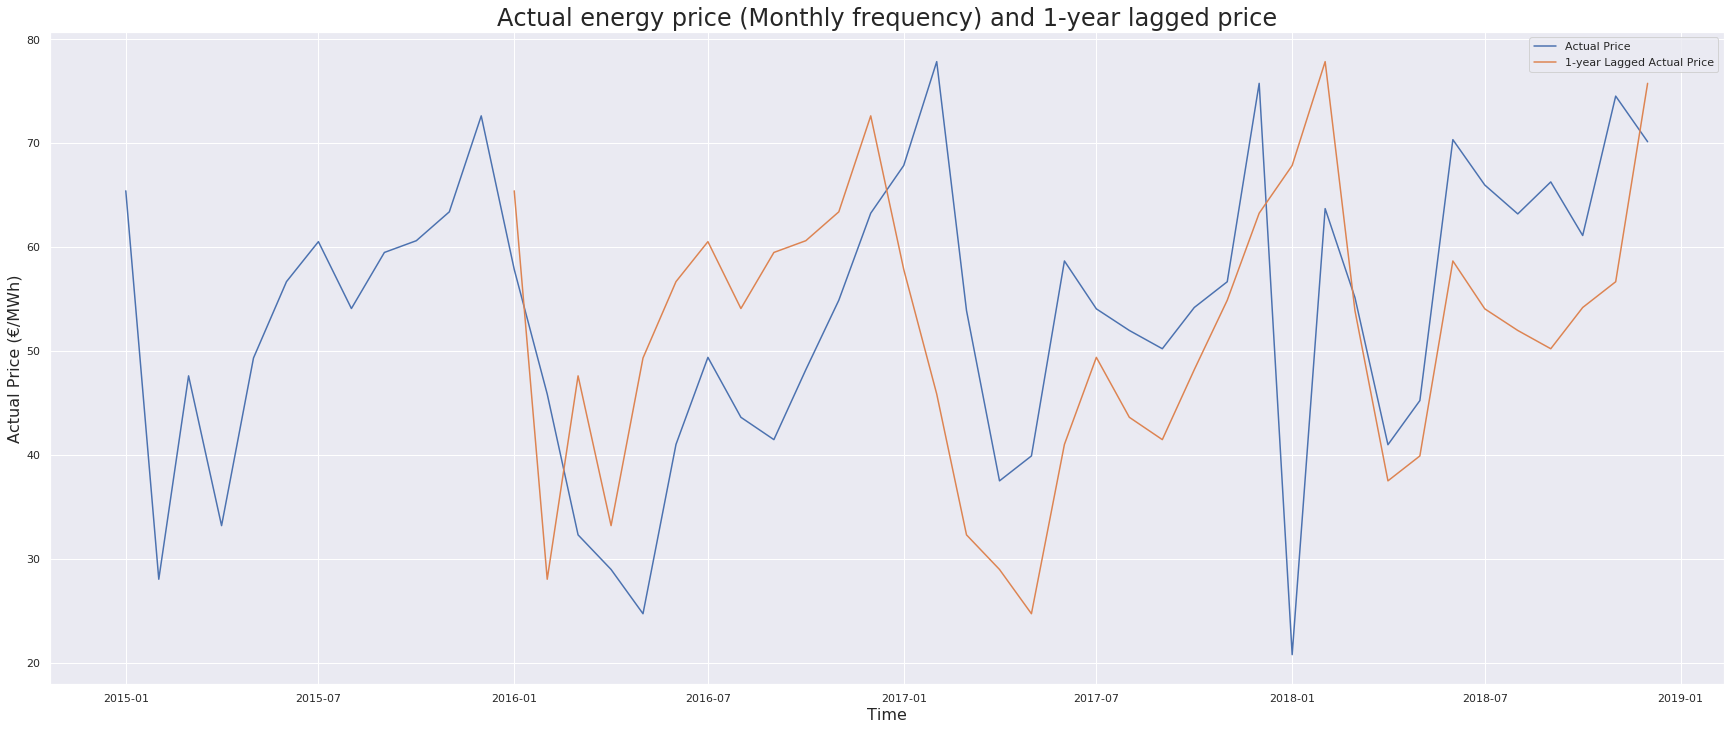

In [69]:
# Plot the energy price (monthly frequence) along with its 1-year lagged series

monthly_price = df_energy['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual energy price (Monthly frequency) and 1-year lagged price')
shifted = df_energy['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

The figure above shows the monthly frequency of the actual energy price, along with its 1-year lagged monthly frequency. From this, we can see that there are indeed seasonal patterns at the monthly scale, as certain "spikes" in the time-series take place in exactly the same months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

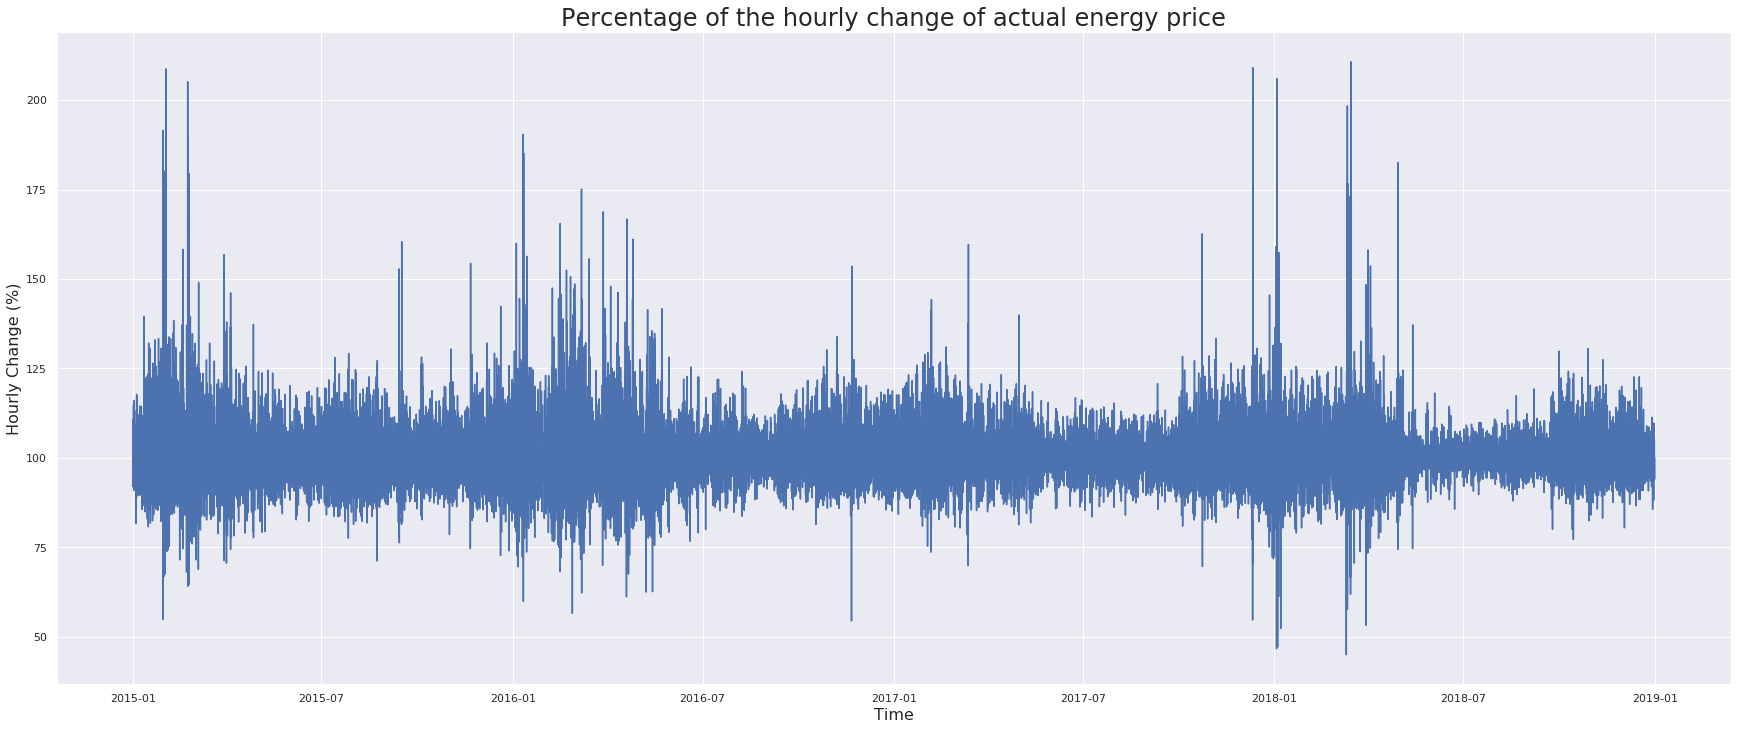

In [70]:
# Plot the percentage of the hourly change in the actual energy price

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change of actual energy price')
plt.show()

From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -25% (actual price \* 0.75) and +25% (actual price \* 1.25). However, there are also very few outliers which show that the price gets halved (-50%) or doubled (+100%).

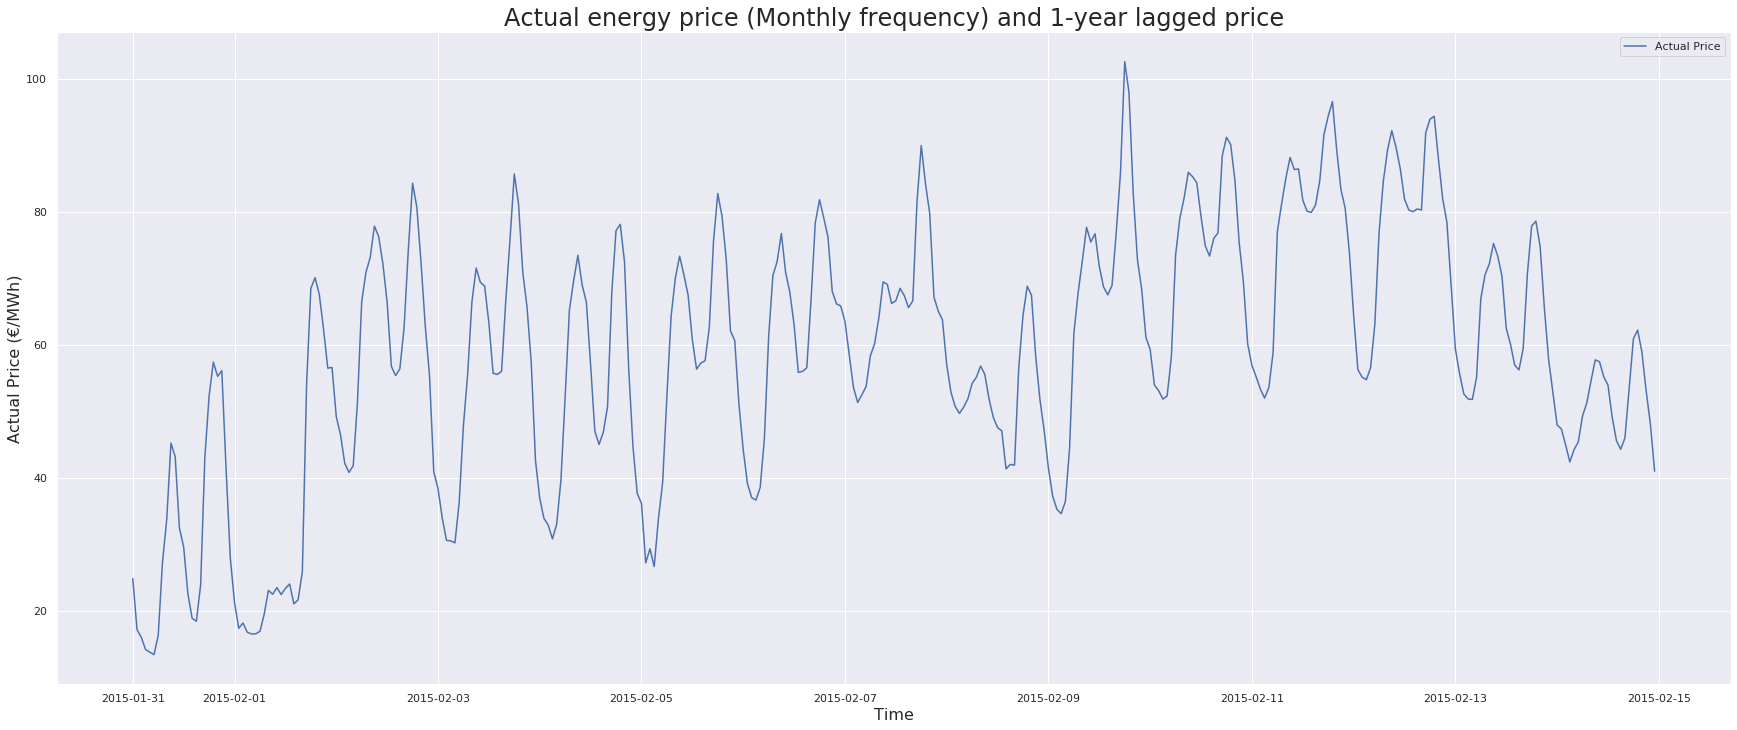

In [71]:
hourly_price = df_final['price actual']
ax = plot_series(series=hourly_price[24*30+1:24*45+1], ylabel='Actual Price (€/MWh)',
                 title='Actual energy price (Monthly frequency) and 1-year lagged price')
#shifted = df_energy['price actual'].shift(24)
#ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

In [72]:
print(df_final['price actual'][24*30+1:24*45+1])

time
2015-01-31 00:00:00+00:00    24.91
2015-01-31 01:00:00+00:00    17.23
2015-01-31 02:00:00+00:00    16.10
2015-01-31 03:00:00+00:00    14.27
2015-01-31 04:00:00+00:00    13.85
                             ...  
2015-02-14 19:00:00+00:00    62.26
2015-02-14 20:00:00+00:00    58.97
2015-02-14 21:00:00+00:00    53.16
2015-02-14 22:00:00+00:00    48.15
2015-02-14 23:00:00+00:00    41.05
Name: price actual, Length: 360, dtype: float64


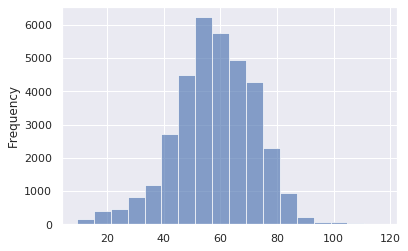

In [73]:
ax = df_energy['price actual'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that the actual energy price roughly follows a normal distribution and thus, can be standardized. However, we also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary. 

### 3.2. Augmented Dickey-Fuller test

The **Augmented Dickey-Fuller (ADF) test**, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [74]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


The ADF statistic (-9.147) is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

### 3.3. Kwiatkowski-Phillips-Schmidt-Shin test

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, follows the opposite logic from Augmented Dickey-Fuller test and checks for  stationarity. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: The time series is level, i.e. it is stationary around a constant.
- **Alternate Hypothesis** $H_{1}$: There is a unit root in the time series and thus it not stationary.

In [75]:
kpss_test = kpss(y, regression='c', lags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 7.957007
p-value: 0.010000
#Lags used: 52
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


/home/dimitriosrou/anaconda3/envs/energy-prediction/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


The KPSS statistic (7.957) is higher than the critical value at 1% (0.739) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that the time series is stationary or stationary around a constant.

Since both tests concluded that the time series is stationary, then we will only apply a 1st order differencing and normalization.

## 4. Feature Engineering

In [80]:
df_final = df_final.drop(['snow_3h_Barcelona',
                          'snow_3h_Seville',
                          'price day ahead',
                          'total load forecast',
                          'forecast solar day ahead',
                          'forecast wind onshore day ahead'], 
                          axis=1)

KeyError: "['snow_3h_Barcelona' 'snow_3h_Seville' 'price day ahead'\n 'total load forecast' 'forecast solar day ahead'\n 'forecast wind onshore day ahead'] not found in axis"

### 4.1. Correlations

In [81]:
# Find the correlations between the energy price and the rest of the features

correlations = df_final.corr()
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0.096279
temp_Valencia                                  0

From the above, we can already see some very interesting correlations among the energy price that we want to predict and the rest of the features. For example, the total energy load and the amount of energy generated from sources related to fossil fuels, is positively correlated with the electricity price. In contrast, the wind speed in almost every city and the amount of storage energy cosumed through hydroelectric pumping is negatively correlated with the energy price.

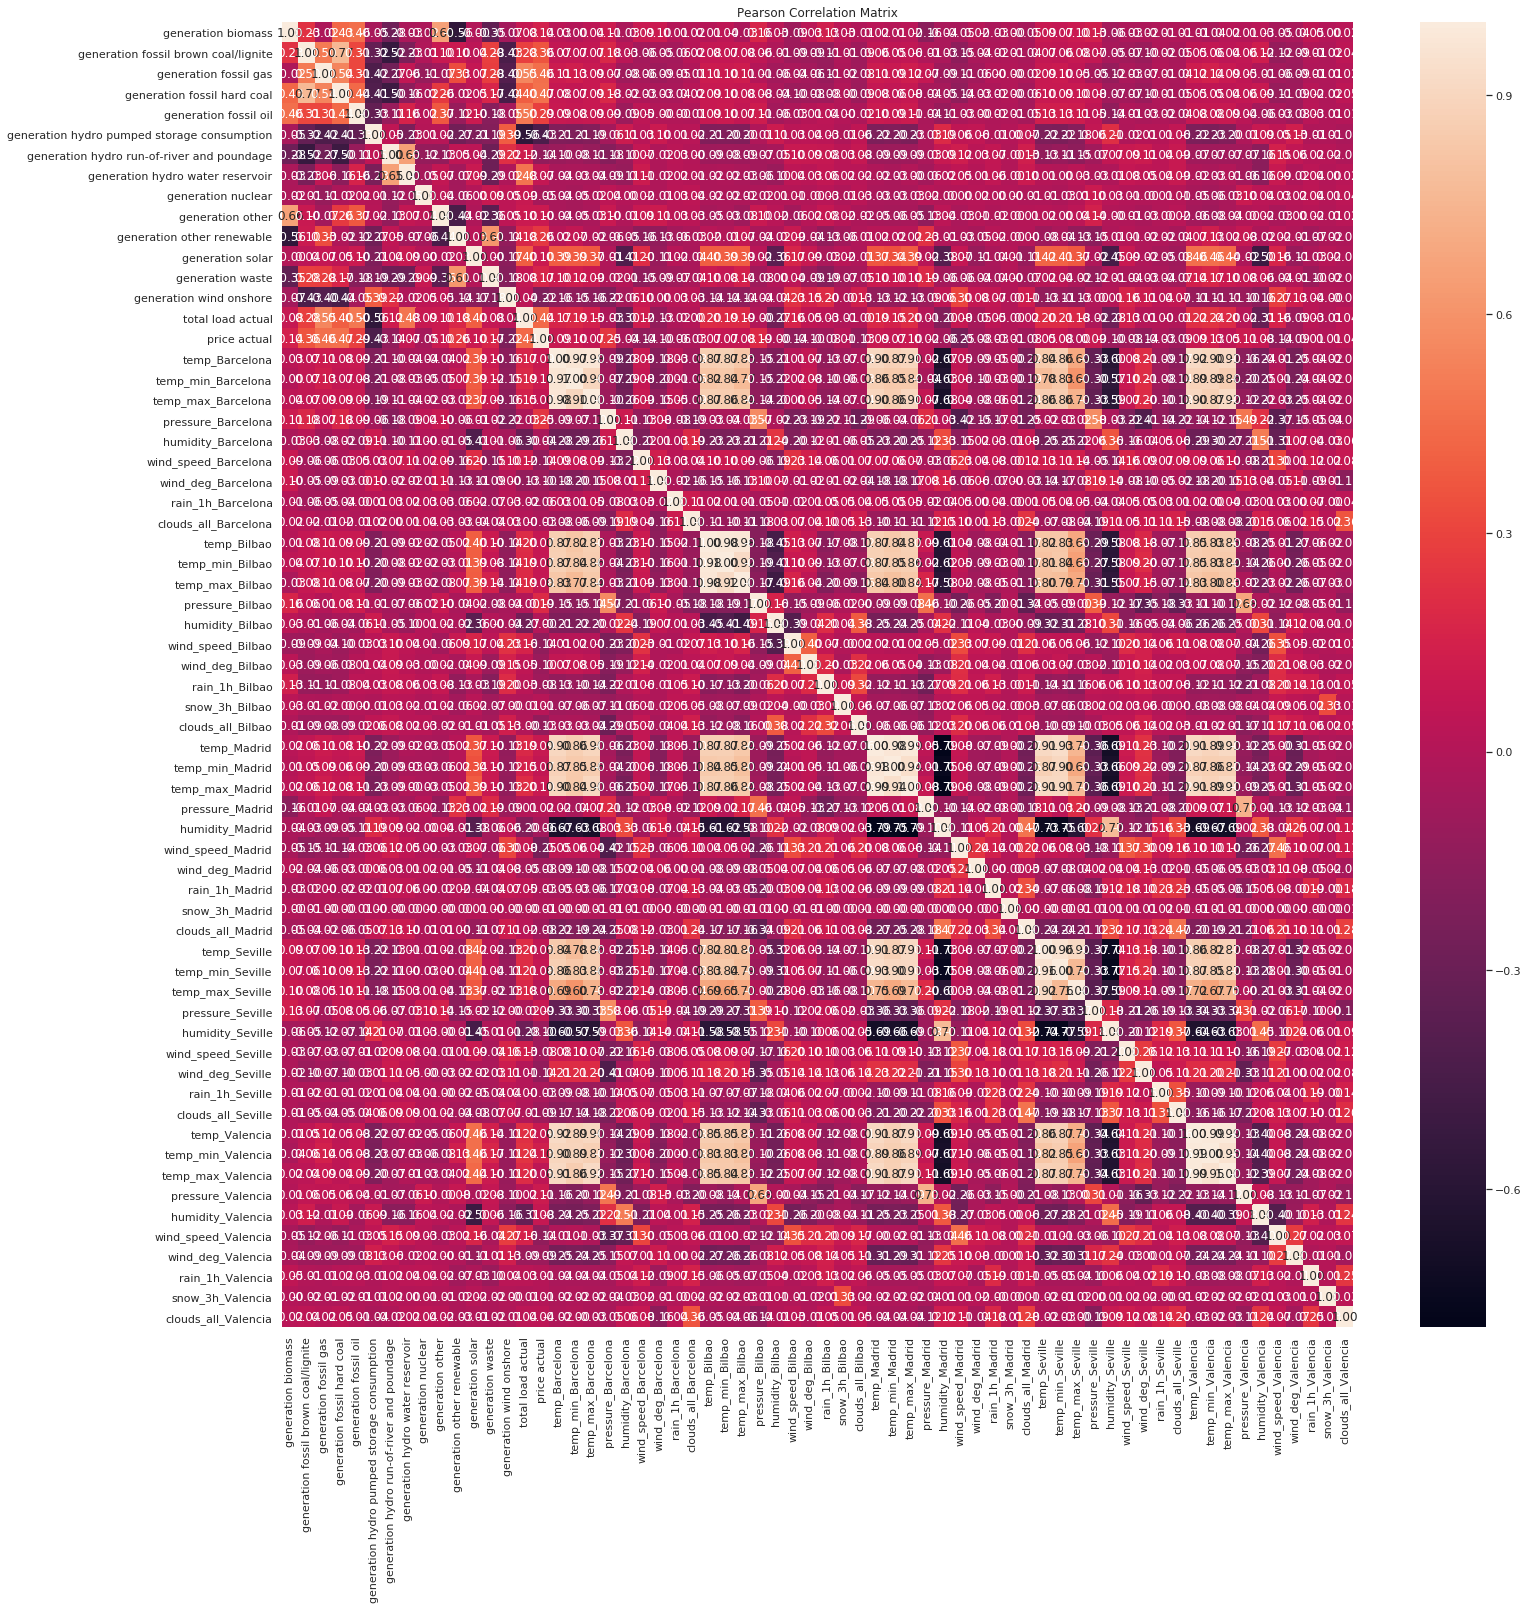

In [235]:
# Plot Pearson correlation matrix

fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

While we cannot make a lot out of the above correlation matrix, we can observe that there quite a lot of features that are highly correlated with each other.

In [84]:
highly_correlated = abs(correlations[correlations > 0.70])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_

What we can observe, is that apart from the amount of energy generated by fossil brown coal/lignit and hard coal, the most correlated features have to do with the temperatures among the different cities, as well the "secondary" information we have about the temperature of each individual city (i.e. the minimunm and maximum temperature).

### 4.2. Feature Generation

The first features that we will generate for a given hour will just be that particular hour, the day and the month in which it falls into.

In [85]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

A very useful feature that we will generate, has to do with the business hours, i.e. whether businesses are open or not in a given hour. However, there is a certain peculiarity in Spain as the 9AM-5PM working day is not generally followed by all types of businesses, due to a lunch break (known as "siesta") in between. The most usual business hours are from Monday-Saturday, from 9:30AM-1:30PM and then again from 4:30PM-8PM.

Therefore, the value of the 'business hour' will be equal to '2' if the given hour is within the business hours, equal to '1' if the given hour is within the "siesta" in between and equal to '0' for all other given hours.

In [86]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

However, we have generated the 'business hour' feature in such a way which also includes weekends, on which fewer -or different types of- businesses are open. Thus, it is useful to also generate another feature, 'weekend', which will distuingish weekdays and weekends, as well as make a distinction between Saturdays and Sundays.

In particular, for a particular given hour, the value of 'weekend' will be equal to '0', if the hours is in a weekday, equal to '1' if the hour is in a Saturday and equal to '2' if the hour is in a Sunday.

In [87]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In order to reduce the dimensionality and potentially acquire a new kind of information, for every given hour, we will subtract the minimum temperature ('temp_min') from the maximum temperature ('temp_max') for each city and we will name that feature 'temp_range_{name of city}'.

In [88]:
# Generate 'temp_range' for each city

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = temp_max - temp_min

After seeing that there is a high correlation among the temperatures of the different cities, we will also try creating a weighted temperature features by taking into account each city's population [[7]](#ref7).

- Madrid: 6,155,116
- Barcelona: 5,179,243
- Valencia: 1,645,342
- Seville: 1,305,342
- Bilbao: 987,000

In [236]:
# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [222]:
cities_weights = {'Madrid': weight_Madrid, 
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [226]:
# Generate 'temp_weighted' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted

### 4.3. Feature Selection

In [227]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

df_train = df_final[:27048]

df_cv = df_final[27048:31056]

In [228]:
y_train = df_train['price actual'].values
y_cv = df_cv['price actual'].values
y_train = y_train.reshape(-1, 1)
y_cv = y_cv.reshape(-1, 1)

X_train = df_train.drop(['price actual'], axis=1)
X_cv = df_cv.drop(['price actual'], axis=1)
names = X_train.columns.values

In [229]:
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_mult = MinMaxScaler(feature_range=(0, 1))

scaler_price.fit(y_train)
scaler_price.transform(y_train)
scaler_price.transform(y_cv)

scaler_mult.fit(X_train)
scaler_mult.transform(X_train)
scaler_mult.transform(X_cv)

array([[0.46114865, 0.        , 0.1286455 , ..., 0.03448276, 0.        ,
        0.24125595],
       [0.44932432, 0.        , 0.12070642, ..., 0.03448276, 0.        ,
        0.21608864],
       [0.4527027 , 0.        , 0.11860013, ..., 0.06896552, 0.        ,
        0.18247671],
       ...,
       [0.55743243, 0.63763764, 0.20549795, ..., 0.06896552, 0.        ,
        0.80393329],
       [0.55067568, 0.63863864, 0.19944913, ..., 0.06896552, 0.        ,
        0.74280754],
       [0.5625    , 0.64564565, 0.17298553, ..., 0.06896552, 0.        ,
        0.7203311 ]])

In [257]:
param = {'eta': 0.03, 'max_depth': 3, 
         'subsample': 1.0, 'colsample_bytree': 0.8, 
         'alpha': 1.5, 'lambda': 1.5, 'gamma': 1.5,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 8, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
dtest = xgb.DMatrix(X_cv, y_cv, feature_names=X_cv.columns.values)
eval_list = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(param, dtrain, 500, eval_list, early_stopping_rounds=10)

[0]	train-rmse:55.7074	eval-rmse:57.1751
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:54.1077	eval-rmse:55.5853
[2]	train-rmse:52.5505	eval-rmse:54.0478
[3]	train-rmse:51.0453	eval-rmse:52.6391
[4]	train-rmse:49.5865	eval-rmse:51.2357
[5]	train-rmse:48.1696	eval-rmse:49.8329
[6]	train-rmse:46.8003	eval-rmse:48.5647
[7]	train-rmse:45.4728	eval-rmse:47.2438
[8]	train-rmse:44.185	eval-rmse:45.9908
[9]	train-rmse:42.9398	eval-rmse:44.7465
[10]	train-rmse:41.7341	eval-rmse:43.631
[11]	train-rmse:40.5656	eval-rmse:42.559
[12]	train-rmse:39.4315	eval-rmse:41.4188
[13]	train-rmse:38.3321	eval-rmse:40.3212
[14]	train-rmse:37.2695	eval-rmse:39.2808
[15]	train-rmse:36.2399	eval-rmse:38.2446
[16]	train-rmse:35.2447	eval-rmse:37.328
[17]	train-rmse:34.2817	eval-rmse:36.3503
[18]	train-rmse:33.3485	eval-rmse:35.4351
[19]	train-rmse:32.4469	eval-rmse:34.5707
[20]	train-rmse:31.5738	eval-rm

[191]	train-rmse:6.80708	eval-rmse:10.1199
[192]	train-rmse:6.79581	eval-rmse:10.1141
[193]	train-rmse:6.78651	eval-rmse:10.1153
[194]	train-rmse:6.77904	eval-rmse:10.1183
[195]	train-rmse:6.77117	eval-rmse:10.12
[196]	train-rmse:6.76394	eval-rmse:10.1205
Stopping. Best iteration:
[186]	train-rmse:6.84876	eval-rmse:10.1061



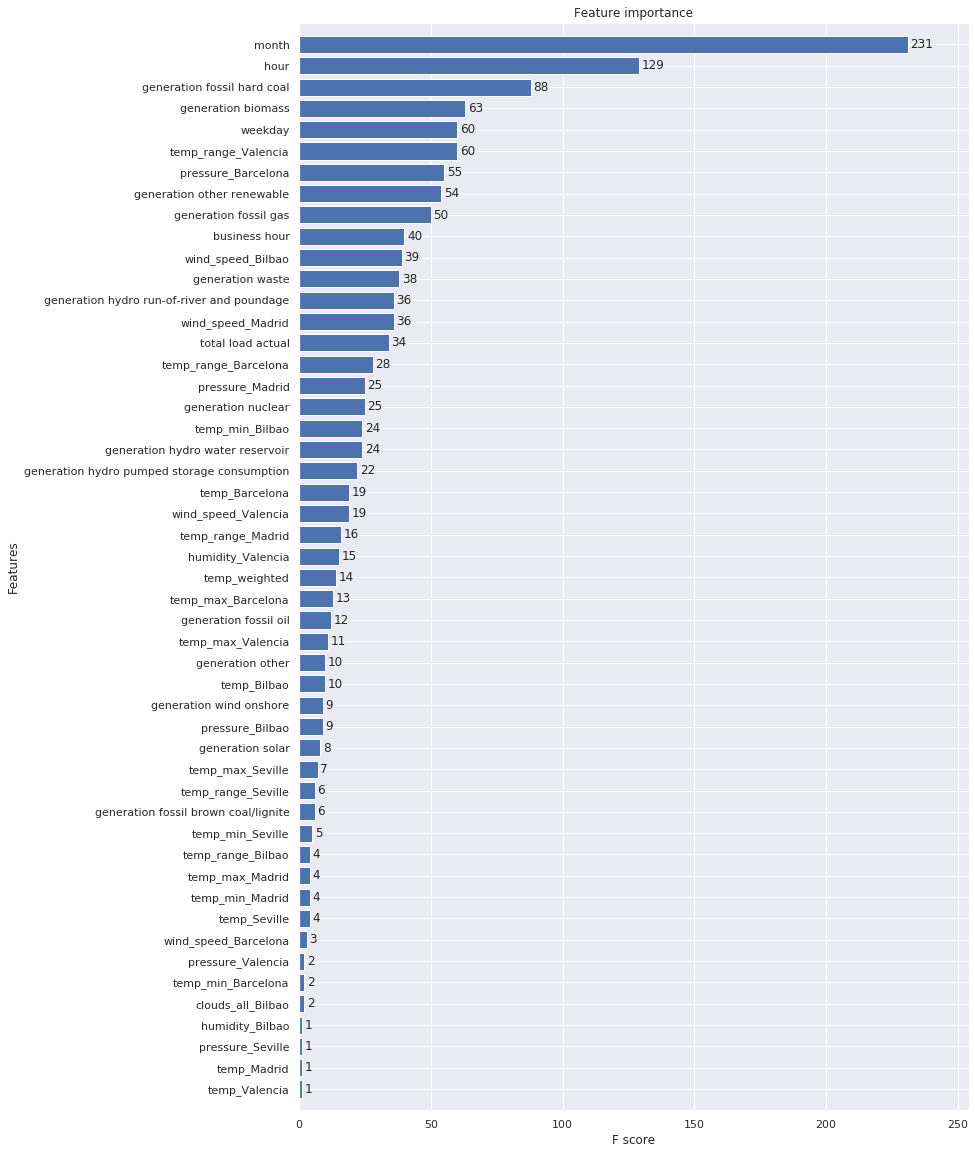

In [258]:
fig, ax = plt.subplots(figsize=(12, 20))
xgb.plot_importance(xgb_model, max_num_features=70, height=0.8, ax=ax)
plt.show()

We will also see again the top correlations of the features with the energy price using the new features and only the training dataset.

In [266]:
correlations = df_train.corr()
correlations_price = abs(correlations['price actual'])
print(correlations_price[correlations_price > 0.20]
      .sort_values(ascending=False).to_string())

price actual                                   1.000000
generation fossil hard coal                    0.536762
generation fossil gas                          0.458981
total load actual                              0.450574
generation fossil brown coal/lignite           0.432460
generation hydro pumped storage consumption    0.411153
generation fossil oil                          0.351272
pressure_Barcelona                             0.287051
business hour                                  0.286860
hour                                           0.248170
generation hydro run-of-river and poundage     0.242460
weekday                                        0.241582
temp_range_Valencia                            0.239328
wind_speed_Madrid                              0.233477
generation biomass                             0.228621
month                                          0.222841
generation wind onshore                        0.202385


Finally, we will choose which features to use for our multivariate models. We will only keep the features which are highly correlated (absolute correlation > 0.20) with 'price actual', as well as those which have a high importance according to XGBoost (F score > 25). These are somewhat arbitrary choices in order to end up with 20 features.

In [469]:
considered_features = ['hour', 'weekday', 'month', 'business hour',
                       'total load actual', 'generation fossil gas',
                       'generation fossil hard coal', 'generation waste',
                       'generation fossil oil', 'generation biomass',
                       'generation hydro pumped storage consumption',
                       'generation hydro run-of-river and poundage',
                       'generation wind onshore', 'generation other renewable', 
                       'generation fossil brown coal/lignite', 
                       'pressure_Barcelona', 'wind_speed_Madrid',
                       'temp_range_Valencia', 'wind_speed_Bilbao', 
                       'wind_speed_Madrid']

In [470]:
len(considered_features)

20

In [768]:
values = df_final[considered_features].values

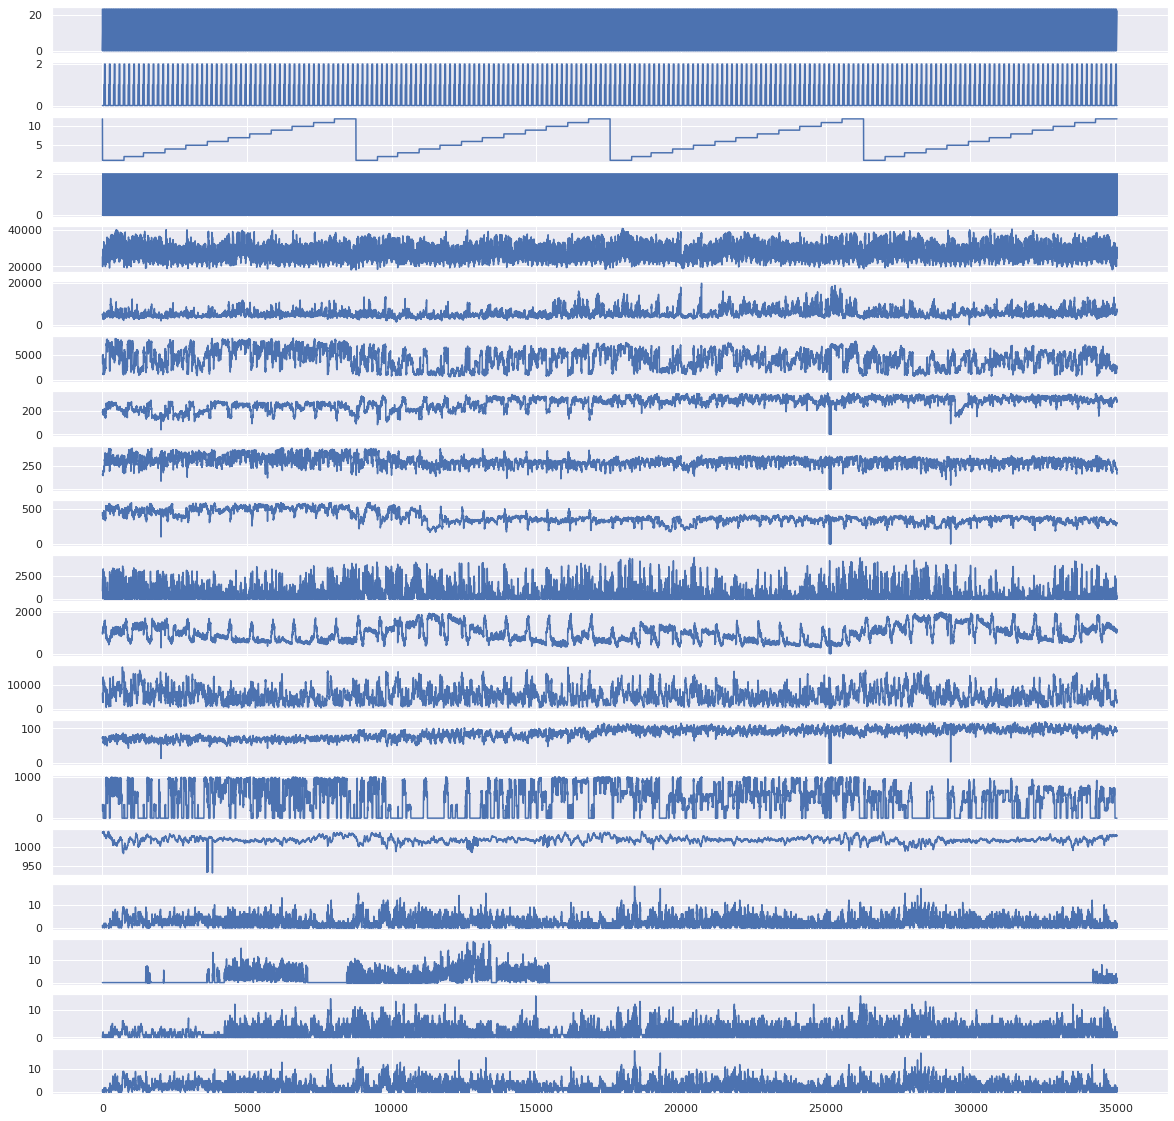

In [771]:
plt.figure(figsize=(20, 20))
for i in range(values.shape[1]):
    plt.subplot(values.shape[1], 1, i+1)
    plt.plot(values[:, i])
plt.show()

## 5. Baseline predictions

### 5.1. Investigating the existing forecast

In [182]:
y = df_final['price actual'].values
y_forecast = df_energy['price day ahead'].values

In [65]:
# Split data into train, cv and test datasets

y_train = y[:27048]
y_cv = y[27048 : 31056]
y_test = y[31056:]

In [66]:
rmse_tso_day = sqrt(mean_squared_error(y_test, y_forecast[31056:]))

print('RMSE of day-ahead energy price forecast by TSO: {}'.format(round(rmse_tso_day, 3)))

RMSE of day-ahead energy price forecast by TSO: 12.332


In [67]:
# Day-ahead naive forecast

naive_day_ahead = y[31056 - 24 : 35064 - 24]
rmse_naive_day = sqrt(mean_squared_error(y_test, naive_day_ahead))

print('RMSE of day-ahead energy price naive forecast: {}'.format(round(rmse_naive_day, 3)))

RMSE of day-ahead energy price naive forecast: 5.637


As we can see above, the day-ahead energy price forecast by the TSO within the dataset is of not reliable and of we can make no use of it, as it is outperformed by a naive forecast, i.e. using the last 24 hours as the predicted output.

### 5.2. Hour-ahead Naive forecast

In [68]:
# Hour-ahead naive forecast

naive_hour_ahead = y[31056 - 1 : 35064 - 1]
rmse_naive = sqrt(mean_squared_error(y_test, naive_hour_ahead))

print('RMSE of hour-ahead energy price naive forecast: {}'.format(round(rmse_naive, 3)))

RMSE of hour-ahead energy price naive forecast: 3.111


We can set this value of RMSE (3.111) as the **baseline** that we want our models to surpass.

## 6. Univariate forecasts

In [1138]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [1139]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [1140]:
def plot_learning_rate_schedule(history_lr, max_loss):
    plt.semilogx(history_lr.history['lr'], history_lr.history['loss'])
    plt.axis([1e-4, 1, 0, max_loss])
    plt.xlabel('Learning Rate')
    plt.ylabel('Training Loss')
    plt.show()

In [1141]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064 - 1 # Because we will apply differencing

In [1146]:
y = df_final['price actual'].values

As the Augmented Dickey-Fuller and the Kwiatkowski-Phillips-Schmidt-Shin tests showed, the time series of energy price ('price actual') is either stationary or can be made stationary with 1st order differencing. Consequently, we will define two functions which transform a time series to a differenced one and vice versa.

In [1147]:
# # Define function for differencing and inversion of differencing

# def difference(data):
#     diff = []
#     for i in range(1, len(data)):
#         value = data[i] - data[i - 1]
#         diff.append(value)
#     return np.array(diff)

# def invert_difference(orig_data, diff_data):
#     inv_diff = []
#     for i in range(1, len(orig_data)):
#         value = diff_data[i - 1] + orig_data[i - 1]
#         inv_diff.append(value)
#     return np.array(inv_diff)

In [1148]:
scaler = MinMaxScaler(feature_range=(0, 1))
y_reshaped = y.reshape(-1, 1)
scaler.fit(y_reshaped[:train_end_idx])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [1149]:
scaled_price = scaler.transform(y_reshaped)

In [1150]:
univariate_past_history = 72
univariate_future_target = 0

In [1151]:
X_train_univ, y_train_univ = univariate_data(scaled_price, 0, train_end_idx,
                                             univariate_past_history,
                                             univariate_future_target)

In [1152]:
X_val_univ, y_val_univ = univariate_data(scaled_price, train_end_idx, cv_end_idx,
                                         univariate_past_history,
                                         univariate_future_target)

In [1153]:
X_test_univ, y_test_univ = univariate_data(scaled_price, cv_end_idx, test_end_idx,
                                           univariate_past_history,
                                           univariate_future_target)

In [1154]:
batch_size = 32
buffer_size = 1000

In [1155]:
train_univ = tf.data.Dataset.from_tensor_slices((X_train_univ, y_train_univ))
train_univ = train_univ.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

In [1156]:
val_univ = tf.data.Dataset.from_tensor_slices((X_val_univ, y_val_univ))
val_univ = val_univ.batch(batch_size).prefetch(1)

In [1157]:
# Define some common parameters

input_shape_univ = X_train_univ.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

In [1159]:
y_test_univ_inv = scaler.inverse_transform(y_test_univ)

### 6.1. Univariate LSTM

In [1162]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_lstm = tf.keras.models.Sequential([
    LSTM(80, input_shape=input_shape_mult, return_sequences=True),
    Flatten(),
    Dense(160, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
univariate_lstm.compile(loss=loss,
                        optimizer=optimizer,
                        metrics=metric)

In [1163]:
history_lr = univariate_lstm.fit(train_univ, epochs=50,
                                 validation_data=val_univ,
                                 callbacks=[lr_schedule])

Epoch 1/50
843/843 [==============================] - 6s 7ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
843/843 [==============================] - 5s 5ms/step - loss: 0.0045 - root_mean_squared_error: 0.0667 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 3/50
843/843 [==============================] - 5s 6ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 4/50
843/843 [==============================] - 5s 5ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 5/50
843/843 [==============================] - 4s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 7.8831e-04 - val_root_mean_squared_error: 0.0281
Epoch 6/50
843/843 [==============================] - 4s 5ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 7

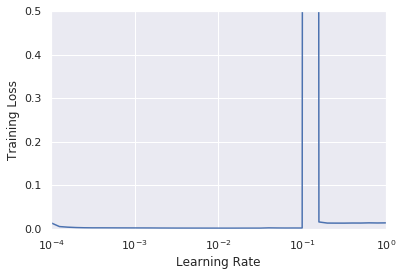

In [1164]:
plot_learning_rate_schedule(history_lr, 0.5)

The learning rate that we will use for Adam is equal to **7e-3**.

In [1165]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_lstm = tf.keras.models.Sequential([
    LSTM(80, input_shape=input_shape_univ, return_sequences=True),
    Flatten(),
    Dense(160, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'univariate_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=7e-3, amsgrad=True)
univariate_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                        optimizer=optimizer,
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [1166]:
history = univariate_lstm.fit(train_univ, epochs=120,
                              validation_data=val_univ,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/120
843/843 [==============================] - 7s 8ms/step - loss: 0.1608 - root_mean_squared_error: 0.4010 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/120
843/843 [==============================] - 5s 6ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 3/120
843/843 [==============================] - 5s 5ms/step - loss: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 4/120
843/843 [==============================] - 5s 6ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 5/120
843/843 [==============================] - 5s 6ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 7.5643e-04 - val_root_mean_squared_error: 0.0275
Epoch 6/120
843/843 [==============================] - 5s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_l

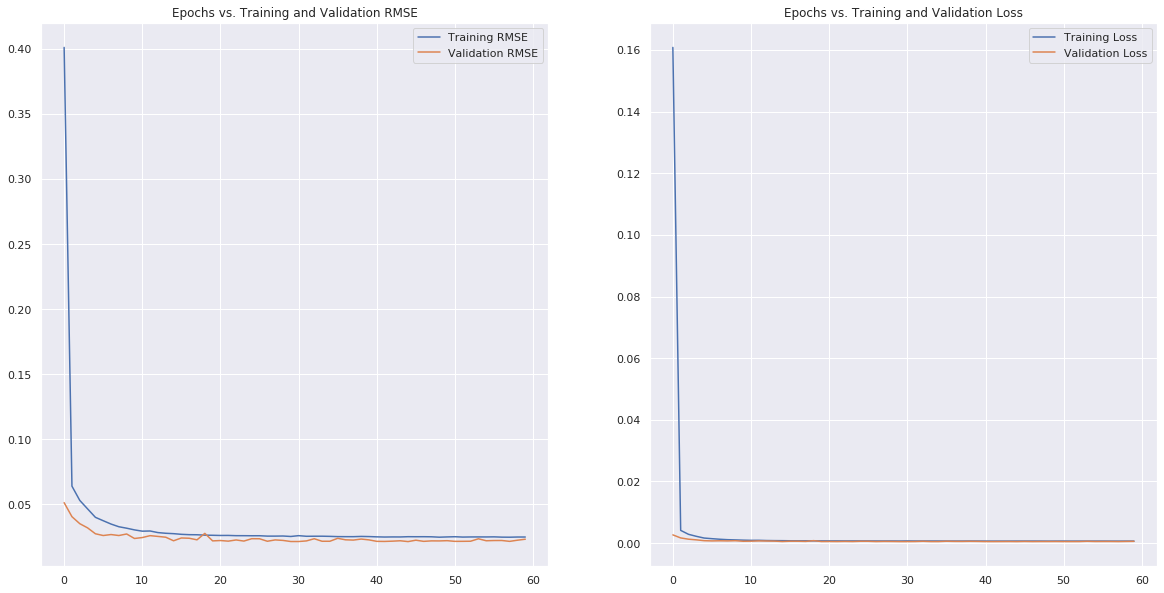

In [1167]:
plot_model_rmse_and_loss(history)

In [1168]:
univariate_lstm = tf.keras.models.load_model('univariate_lstm.h5')

forecast = univariate_lstm.predict(X_test_univ)
univariate_lstm_forecast = scaler.inverse_transform(forecast)

rmse_univ_lstm = sqrt(mean_squared_error(y_test_univ_inv,
                                         univariate_lstm_forecast))
print('RMSE of hour-ahead energy price univariate LSTM forecast: {}'
      .format(round(rmse_univ_lstm, 3)))

RMSE of hour-ahead energy price univariate LSTM forecast: 1.998


**RMSE = 1.998**

### 6.2. Univariate Stacked LSTM

In [1169]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape_mult, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.05),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
univariate_stacked_lstm.compile(loss=loss,
                        optimizer=optimizer,
                        metrics=metric)

In [1170]:
history_lr = univariate_stacked_lstm.fit(train_univ, epochs=50,
                                         validation_data=val_univ,
                                         callbacks=[lr_schedule])

Epoch 1/50
843/843 [==============================] - 13s 16ms/step - loss: 0.0108 - root_mean_squared_error: 0.1038 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
843/843 [==============================] - 11s 13ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 3/50
843/843 [==============================] - 11s 13ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 9.0531e-04 - val_root_mean_squared_error: 0.0301
Epoch 4/50
843/843 [==============================] - 10s 12ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 6.8930e-04 - val_root_mean_squared_error: 0.0263
Epoch 5/50
843/843 [==============================] - 11s 13ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 9.1846e-04 - val_root_mean_squared_error: 0.0303
Epoch 6/50
843/843 [==============================] - 11s 13ms/step - loss: 0.0010 - root_mean_squared_error: 

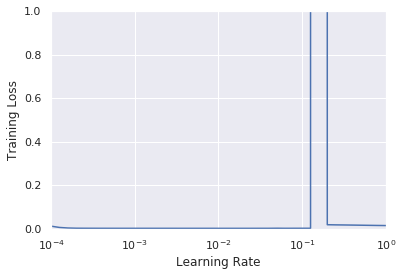

In [1171]:
plot_learning_rate_schedule(history_lr, 1)

The learning rate that we will use for Adam is equal to **8e-3**.

In [1172]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(200, input_shape=input_shape_univ, 
         return_sequences=True),
    LSTM(150),
    Dense(150, activation='relu'),
    Dropout(0.05),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'univariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=8e-3, amsgrad=True)
univariate_stacked_lstm.compile(loss=loss,
                                optimizer=optimizer,
                                metrics=metric)

In [1173]:
history = univariate_stacked_lstm.fit(train_univ, epochs=120,
                                      validation_data=val_univ,
                                      callbacks=[early_stopping, 
                                                 model_checkpoint])

Epoch 1/120
843/843 [==============================] - 13s 16ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/120
843/843 [==============================] - 11s 13ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 7.2537e-04 - val_root_mean_squared_error: 0.0269
Epoch 3/120
843/843 [==============================] - 11s 12ms/step - loss: 9.0185e-04 - root_mean_squared_error: 0.0300 - val_loss: 5.9919e-04 - val_root_mean_squared_error: 0.0245
Epoch 4/120
843/843 [==============================] - 11s 13ms/step - loss: 8.2182e-04 - root_mean_squared_error: 0.0287 - val_loss: 5.8961e-04 - val_root_mean_squared_error: 0.0243
Epoch 5/120
843/843 [==============================] - 11s 12ms/step - loss: 8.1274e-04 - root_mean_squared_error: 0.0285 - val_loss: 5.7885e-04 - val_root_mean_squared_error: 0.0241
Epoch 6/120
843/843 [==============================] - 11s 13ms/step - loss: 7.8306e-04 -

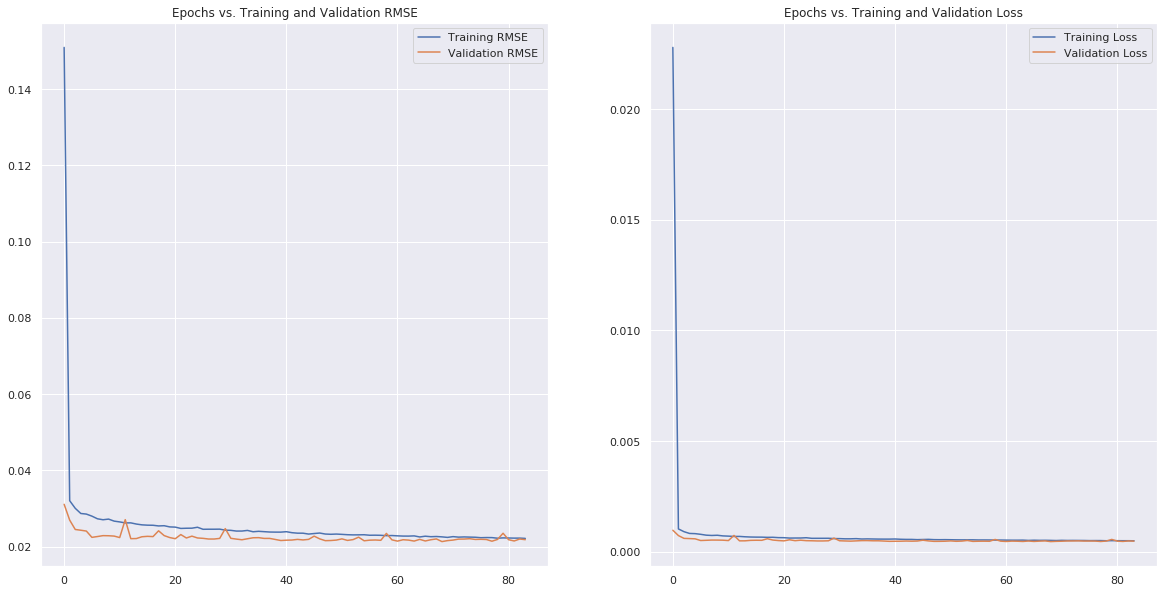

In [1174]:
plot_model_rmse_and_loss(history)

In [1175]:
univariate_stacked_lstm = tf.keras.models.load_model('univariate_stacked_lstm.h5')

forecast = univariate_stacked_lstm.predict(X_test_univ)
univariate_stacked_lstm_forecast = scaler.inverse_transform(forecast)

rmse_univ_stacked_lstm = sqrt(mean_squared_error(y_test_univ_inv,
                                                 univariate_stacked_lstm_forecast))
print('RMSE of hour-ahead energy price univariate Stacked LSTM forecast: {}'
      .format(round(rmse_univ_stacked_lstm, 3)))

RMSE of hour-ahead energy price univariate Stacked LSTM forecast: 1.998


**RMSE = 1.998**

### 6.3. Univariate CNN forecast

In [1176]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=64, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape_univ),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(80, activation='relu'),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
univariate_cnn.compile(loss=loss,
                       optimizer=optimizer,
                       metrics=metric)

In [1177]:
history_lr = univariate_cnn.fit(train_univ, epochs=50,
                                validation_data=val_univ,
                                callbacks=[lr_schedule])

Epoch 1/50
843/843 [==============================] - 3s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
843/843 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 9.6340e-04 - val_root_mean_squared_error: 0.0310
Epoch 3/50
843/843 [==============================] - 2s 2ms/step - loss: 8.7529e-04 - root_mean_squared_error: 0.0296 - val_loss: 7.5622e-04 - val_root_mean_squared_error: 0.0275
Epoch 4/50
843/843 [==============================] - 2s 2ms/step - loss: 7.4867e-04 - root_mean_squared_error: 0.0274 - val_loss: 6.5866e-04 - val_root_mean_squared_error: 0.0257
Epoch 5/50
843/843 [==============================] - 2s 2ms/step - loss: 6.8810e-04 - root_mean_squared_error: 0.0262 - val_loss: 5.9108e-04 - val_root_mean_squared_error: 0.0243
Epoch 6/50
843/843 [==============================] - 2s 2ms/step - loss: 6.4949e-04 - root_mean_squared

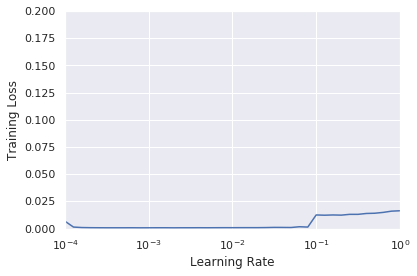

In [1178]:
plot_learning_rate_schedule(history_lr, 0.2)

The learning rate that we will use for Adam is equal to **6e-3**.

In [1179]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=64, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape_univ),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(80, activation='relu'),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'univariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)
univariate_cnn.compile(loss=tf.keras.losses.MeanSquaredError(),
                       optimizer=optimizer,
                       metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [1180]:
history = univariate_cnn.fit(train_univ, epochs=120,
                             validation_data=val_univ,
                             callbacks=[early_stopping, 
                                        model_checkpoint])

Epoch 1/80
843/843 [==============================] - 3s 3ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/80
843/843 [==============================] - 2s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 3/80
843/843 [==============================] - 2s 2ms/step - loss: 9.9888e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 4/80
843/843 [==============================] - 2s 2ms/step - loss: 8.7420e-04 - root_mean_squared_error: 0.0296 - val_loss: 6.9150e-04 - val_root_mean_squared_error: 0.0263
Epoch 5/80
843/843 [==============================] - 2s 2ms/step - loss: 7.8229e-04 - root_mean_squared_error: 0.0280 - val_loss: 7.2716e-04 - val_root_mean_squared_error: 0.0270
Epoch 6/80
843/843 [==============================] - 2s 2ms/step - loss: 7.4086e-04 - root_mean_squared_error: 

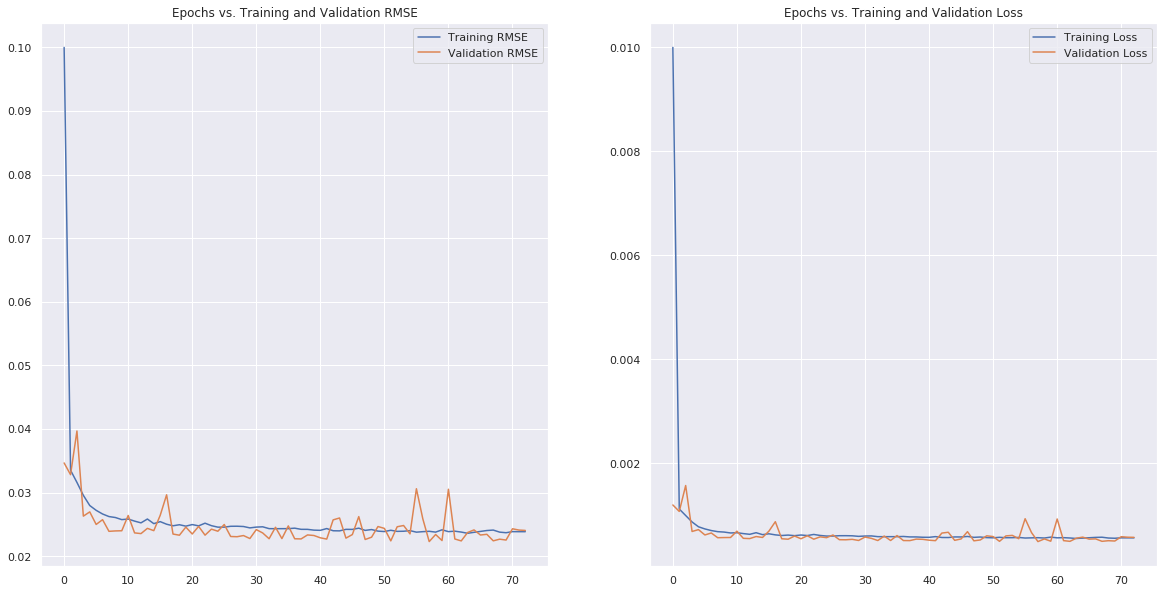

In [1181]:
plot_model_rmse_and_loss(history)

In [1182]:
univariate_cnn = tf.keras.models.load_model('univariate_cnn.h5')

forecast = univariate_cnn.predict(X_test_univ)
univariate_cnn_forecast = scaler.inverse_transform(forecast)

rmse_univ_cnn = sqrt(mean_squared_error(y_test_univ_inv, 
                                        univariate_cnn_forecast))
print('RMSE of hour-ahead energy price univariate CNN forecast: {}'
      .format(round(rmse_univ_cnn, 3)))

RMSE of hour-ahead energy price univariate CNN forecast: 2.082


**RMSE = 2.082**

### 6.4. Univariate CNN-LSTM forecast

In [1192]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=72, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape_univ),
    LSTM(120, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
univariate_cnn_lstm.compile(loss=loss,
                            optimizer=optimizer,
                            metrics=metric)

In [1193]:
history_lr = univariate_cnn_lstm.fit(train_univ, epochs=50,
                                     validation_data=val_univ,
                                     callbacks=[lr_schedule])

Epoch 1/50
843/843 [==============================] - 7s 8ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
843/843 [==============================] - 5s 6ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 3/50
843/843 [==============================] - 5s 6ms/step - loss: 9.3631e-04 - root_mean_squared_error: 0.0306 - val_loss: 8.1400e-04 - val_root_mean_squared_error: 0.0285
Epoch 4/50
843/843 [==============================] - 5s 6ms/step - loss: 6.7273e-04 - root_mean_squared_error: 0.0259 - val_loss: 8.1539e-04 - val_root_mean_squared_error: 0.0286
Epoch 5/50
843/843 [==============================] - 5s 6ms/step - loss: 5.8226e-04 - root_mean_squared_error: 0.0241 - val_loss: 4.9883e-04 - val_root_mean_squared_error: 0.0223
Epoch 6/50
843/843 [==============================] - 5s 6ms/step - loss: 5.6533e-04 - root_mean_squared_err

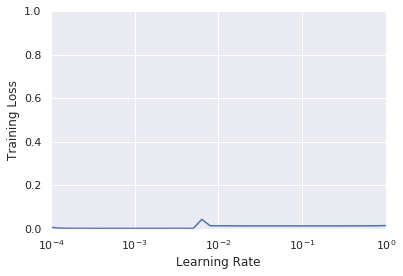

In [1194]:
plot_learning_rate_schedule(history_lr, 1)

The learning rate that we will use for Adam is equal to **1e-3**.

In [1195]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=72, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape_univ),
    LSTM(100),
    Dense(50, activation='relu'),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'univariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)
univariate_cnn_lstm.compile(loss=loss,
                            optimizer=optimizer,
                            metrics=metric)

In [1196]:
history = univariate_cnn_lstm.fit(train_univ, epochs=120,
                                  validation_data=val_univ,
                                  callbacks=[early_stopping, 
                                             model_checkpoint])

Epoch 1/120
843/843 [==============================] - 7s 8ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/120
843/843 [==============================] - 6s 7ms/step - loss: 8.3101e-04 - root_mean_squared_error: 0.0288 - val_loss: 6.7360e-04 - val_root_mean_squared_error: 0.0260
Epoch 3/120
843/843 [==============================] - 6s 7ms/step - loss: 8.1001e-04 - root_mean_squared_error: 0.0285 - val_loss: 6.3516e-04 - val_root_mean_squared_error: 0.0252
Epoch 4/120
843/843 [==============================] - 6s 7ms/step - loss: 7.9250e-04 - root_mean_squared_error: 0.0282 - val_loss: 6.1140e-04 - val_root_mean_squared_error: 0.0247
Epoch 5/120
843/843 [==============================] - 6s 7ms/step - loss: 7.5025e-04 - root_mean_squared_error: 0.0274 - val_loss: 6.7391e-04 - val_root_mean_squared_error: 0.0260
Epoch 6/120
843/843 [==============================] - 6s 7ms/step - loss: 6.9851e-04 - root_me

843/843 [==============================] - 5s 6ms/step - loss: 5.1710e-04 - root_mean_squared_error: 0.0227 - val_loss: 5.1033e-04 - val_root_mean_squared_error: 0.0226
Epoch 47/120
843/843 [==============================] - 6s 7ms/step - loss: 5.1448e-04 - root_mean_squared_error: 0.0227 - val_loss: 4.7955e-04 - val_root_mean_squared_error: 0.0219
Epoch 48/120
843/843 [==============================] - 5s 6ms/step - loss: 5.1553e-04 - root_mean_squared_error: 0.0227 - val_loss: 4.8185e-04 - val_root_mean_squared_error: 0.0220
Epoch 49/120
843/843 [==============================] - 6s 7ms/step - loss: 5.1619e-04 - root_mean_squared_error: 0.0227 - val_loss: 4.7343e-04 - val_root_mean_squared_error: 0.0218
Epoch 50/120
843/843 [==============================] - 6s 7ms/step - loss: 5.1453e-04 - root_mean_squared_error: 0.0227 - val_loss: 4.6472e-04 - val_root_mean_squared_error: 0.0216
Epoch 51/120
843/843 [==============================] - 6s 7ms/step - loss: 5.1555e-04 - root_mean_squa

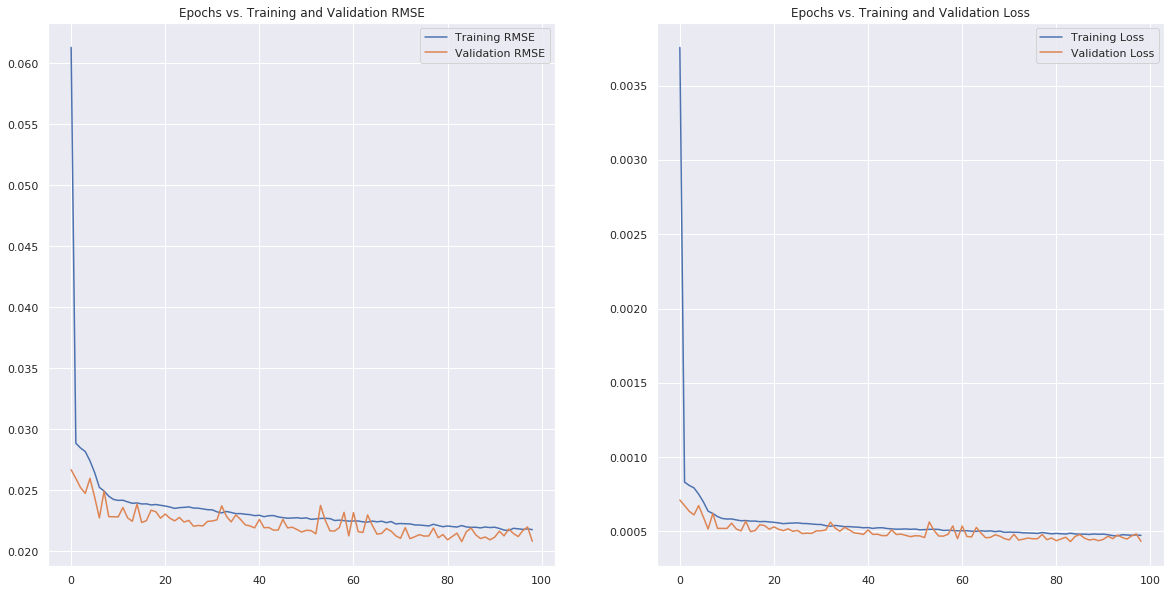

In [1197]:
plot_model_rmse_and_loss(history)

In [1198]:
univariate_cnn_lstm = tf.keras.models.load_model('univariate_cnn_lstm.h5')

forecast = univariate_cnn_lstm.predict(X_test_univ)
univariate_cnn_lstm_forecast = scaler.inverse_transform(forecast)

rmse_univ_cnn_lstm = sqrt(mean_squared_error(y_test_univ_inv, 
                                             univariate_cnn_lstm_forecast))
print('RMSE of hour-ahead energy price univariate CNN-LSTM forecast: {}'
      .format(round(rmse_univ_cnn_lstm, 3)))

RMSE of hour-ahead energy price univariate CNN-LSTM forecast: 2.017


**RMSE = 2.017** (filters=24)

### 6.5. Univariate MLP forecast

In [1199]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(72, activation='relu'),
                    input_shape=input_shape_univ),
    TimeDistributed(Dense(48, activation='relu')),
    TimeDistributed(Dense(24, activation='relu')),
    TimeDistributed(Dense(12, activation='relu')),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
univariate_mlp.compile(loss=loss,
                       optimizer=optimizer,
                       metrics=metric)

In [1200]:
history_lr = univariate_mlp.fit(train_univ, epochs=50,
                                validation_data=val_univ,
                                callbacks=[lr_schedule])

Epoch 1/50
843/843 [==============================] - 3s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
843/843 [==============================] - 2s 2ms/step - loss: 9.8166e-04 - root_mean_squared_error: 0.0313 - val_loss: 7.2577e-04 - val_root_mean_squared_error: 0.0269
Epoch 3/50
843/843 [==============================] - 2s 2ms/step - loss: 7.6042e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 4/50
843/843 [==============================] - 2s 2ms/step - loss: 7.2228e-04 - root_mean_squared_error: 0.0269 - val_loss: 7.1121e-04 - val_root_mean_squared_error: 0.0267
Epoch 5/50
843/843 [==============================] - 2s 2ms/step - loss: 6.8059e-04 - root_mean_squared_error: 0.0261 - val_loss: 6.8504e-04 - val_root_mean_squared_error: 0.0262
Epoch 6/50
843/843 [==============================] - 2s 2ms/step - loss: 6.3215e-04 - root_mean_squared

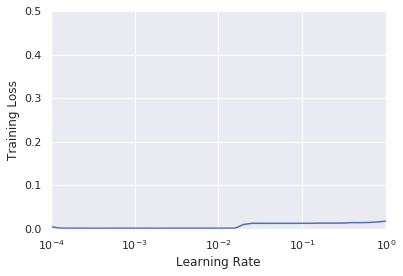

In [1201]:
plot_learning_rate_schedule(history_lr, 0.5)

The learning rate that we will use for Adam is equal to **7e-3**.

In [1227]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

univariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(72, activation='relu'),
                    input_shape=input_shape_univ),
    TimeDistributed(Dense(48, activation='relu')),
    TimeDistributed(Dense(24, activation='relu')),
    TimeDistributed(Dense(12, activation='relu')),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'univariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)
univariate_mlp.compile(loss=loss,
                       optimizer=optimizer,
                       metrics=metric)

In [1229]:
history = univariate_mlp.fit(train_univ, epochs=120,
                             validation_data=val_univ,
                             callbacks=[early_stopping, 
                                        model_checkpoint])

Epoch 1/120
843/843 [==============================] - 3s 4ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/120
843/843 [==============================] - 2s 3ms/step - loss: 8.5912e-04 - root_mean_squared_error: 0.0293 - val_loss: 6.6497e-04 - val_root_mean_squared_error: 0.0258
Epoch 3/120
843/843 [==============================] - 2s 2ms/step - loss: 7.1384e-04 - root_mean_squared_error: 0.0267 - val_loss: 7.0714e-04 - val_root_mean_squared_error: 0.0266
Epoch 4/120
843/843 [==============================] - 2s 2ms/step - loss: 6.9570e-04 - root_mean_squared_error: 0.0264 - val_loss: 9.1368e-04 - val_root_mean_squared_error: 0.0302
Epoch 5/120
843/843 [==============================] - 2s 3ms/step - loss: 6.2861e-04 - root_mean_squared_error: 0.0251 - val_loss: 5.0648e-04 - val_root_mean_squared_error: 0.0225
Epoch 6/120
843/843 [==============================] - 2s 3ms/step - loss: 6.1766e-04 - root_me

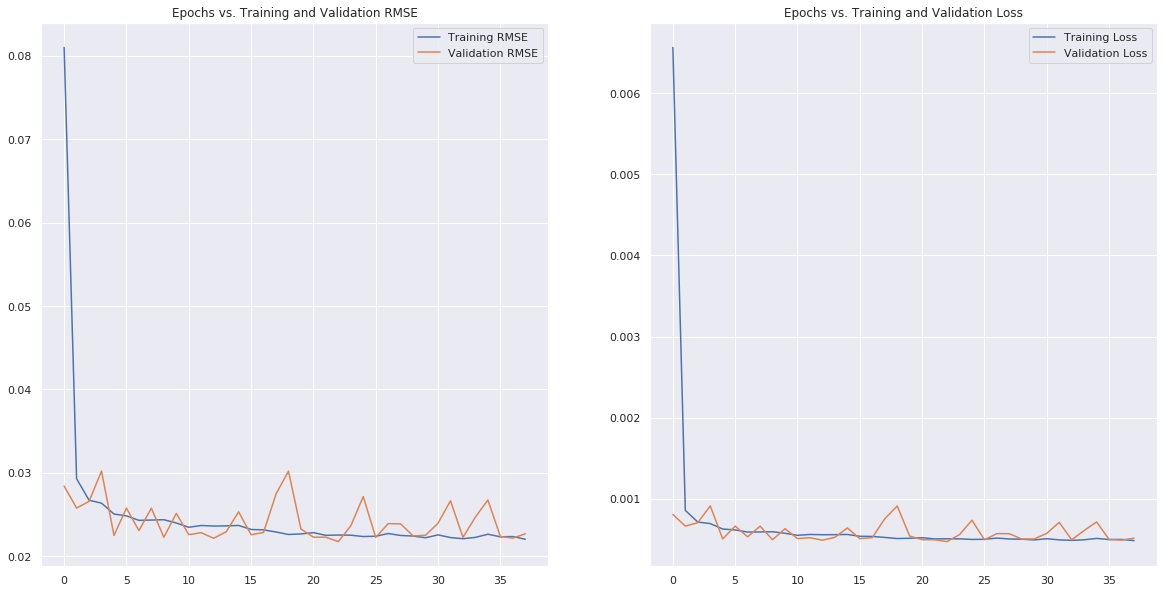

In [1230]:
plot_model_rmse_and_loss(history)

In [1231]:
univariate_mlp = tf.keras.models.load_model('univariate_mlp.h5')

forecast = univariate_mlp.predict(X_test_univ)
univariate_mlp_forecast = scaler.inverse_transform(forecast)

rmse_univ_mlp = sqrt(mean_squared_error(y_test_univ_inv, 
                                        univariate_mlp_forecast))
print('RMSE of hour-ahead energy price univariate MLP forecast: {}'
      .format(round(rmse_univ_mlp, 3)))

RMSE of hour-ahead energy price univariate MLP forecast: 1.996


**RMSE = 1.979**

## 7. Multivariate forecasts

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [ ]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [ ]:
dataset = df_final[considered_features]

In [ ]:
scaler_mult = MinMaxScaler(feature_range=(0, 1))

scaler_mult.fit(dataset[:train_end_idx])

In [ ]:
y = df_final['price actual'].values

scaler = MinMaxScaler(feature_range=(0, 1))

y_reshaped = y.reshape(-1, 1)
scaler.fit(y_reshaped[:train_end_idx])

scaled_price = scaler.transform(y_reshaped)

In [ ]:
scaled_dataset = scaler_mult.transform(dataset)

In [ ]:
scaled_dataset = np.concatenate((scaled_dataset, scaled_price), axis=1)

In [ ]:
multivariate_past_history = 72
multivariate_future_target = 0

In [ ]:
X_train_mult, y_train_mult = multivariate_data(scaled_dataset, scaled_dataset[:, -1],
                                               0, train_end_idx, 
                                               multivariate_past_history,
                                               multivariate_future_target,
                                               step=1, single_step=True)

In [ ]:
X_val_mult, y_val_mult = multivariate_data(scaled_dataset, scaled_dataset[:, -1],
                                           train_end_idx, cv_end_idx, 
                                           multivariate_past_history,
                                           multivariate_future_target,
                                           step=1, single_step=True)

In [ ]:
X_test_mult, y_test_mult = multivariate_data(scaled_dataset, scaled_dataset[:, -1],
                                             cv_end_idx, test_end_idx,
                                             multivariate_past_history,
                                             multivariate_future_target,
                                             step=1, single_step=True)

In [ ]:
batch_size = 32
buffer_size = 1000

In [ ]:
train_mult = tf.data.Dataset.from_tensor_slices((X_train_mult, y_train_mult))
train_mult = train_mult.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

In [ ]:
val_mult = tf.data.Dataset.from_tensor_slices((X_val_mult, y_val_mult))
val_mult = val_mult.batch(batch_size).prefetch(1)

In [ ]:
# Define some common parameters

input_shape_mult = X_train_mult.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

In [ ]:
y_test_mult_reshaped = y_test_mult.reshape(-1, 1)
y_test_mult_inv = scaler.inverse_transform(y_test_mult_reshaped)

### 7.1. Multivariate LSTM

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(80, input_shape=input_shape_mult, return_sequences=True),
    Flatten(),
    Dense(160, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history_lr = multivariate_lstm.fit(train_mult, epochs=50,
                                   validation_data=val_mult,
                                   callbacks=[lr_schedule])

In [ ]:
plot_learning_rate_schedule(history_lr, 0.5)

The learning rate that we will use for Adam is equal to **3e-3**.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(80, input_shape=input_shape_mult, return_sequences=True),
    Flatten(),
    Dense(160, activation='relu'),
    Dropout(0.05),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=8e-3, amsgrad=True)
multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history = multivariate_lstm.fit(train_mult, epochs=120,
                                validation_data=val_mult,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test_mult)
multivariate_lstm_forecast = scaler.inverse_transform(forecast)

rmse_mult_lstm = sqrt(mean_squared_error(y_test_mult_inv,
                                         multivariate_lstm_forecast))
print('RMSE of hour-ahead energy price multivariate LSTM forecast: {}'
      .format(round(rmse_mult_lstm, 3)))

**RMSE = 2.041**

### 7.2. Multivariate Stacked LSTM

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape_mult, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.05),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
multivariate_stacked_lstm.compile(loss=loss,
                        optimizer=optimizer,
                        metrics=metric)

In [ ]:
multivariate_stacked_lstm.summary()

In [ ]:
history_lr = multivariate_stacked_lstm.fit(train_mult, epochs=50,
                                           validation_data=val_mult,
                                           callbacks=[lr_schedule])

In [ ]:
plot_learning_rate_schedule(history_lr, 1)

The learning rate that we will use for Adam is equal to **4e-3**.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape_mult, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.05),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=9e-4, amsgrad=True)
multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [ ]:
history = multivariate_stacked_lstm.fit(train_mult, epochs=120,
                                        validation_data=val_mult,
                                        callbacks=[early_stopping, 
                                                   model_checkpoint])

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test_mult)
multivariate_stacked_lstm_forecast = scaler.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_mult_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead energy price multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))

**RMSE = 2.081**

### 7.3. Multivariate CNN

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=64, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape_mult),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(80, activation='relu'),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
multivariate_cnn.compile(loss=loss,
                         optimizer=optimizer,
                         metrics=metric)

In [ ]:
history_lr = multivariate_cnn.fit(train_mult, epochs=50,
                                  validation_data=val_mult,
                                  callbacks=[lr_schedule])

In [ ]:
plot_learning_rate_schedule(history_lr, 0.5)

The learning rate that we will use for Adam is equal to **8e-3**.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=64, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape_mult),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(80, activation='relu'),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=8e-3, amsgrad=True)
multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history = multivariate_cnn.fit(train_mult, epochs=120,
                               validation_data=val_mult,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test_mult)
multivariate_cnn_forecast = scaler.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_mult_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead energy price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

**RMSE = 2.501**

### 7.4. Multivariate CNN-LSTM

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=72, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape_mult),
    LSTM(120, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
multivariate_cnn_lstm.compile(loss=loss,
                         optimizer=optimizer,
                         metrics=metric)

In [ ]:
history_lr = multivariate_cnn_lstm.fit(train_mult, epochs=50,
                                       validation_data=val_mult,
                                       callbacks=[lr_schedule])

In [ ]:
plot_learning_rate_schedule(history_lr, 1)

The learning rate that we will use for Adam is equal to **8e-3**.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=24, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape_mult),
    LSTM(120, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=7e-4, amsgrad=True)
multivariate_cnn_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                          optimizer=optimizer,
                          metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = multivariate_cnn_lstm.fit(train_mult, epochs=120,
                                    validation_data=val_mult,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test_mult)
multivariate_cnn_lstm_forecast = scaler.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_mult_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead energy price multivariate CNN-LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

**RMSE = 2.123** (RMSE=1.986 with t=72)

### 7.5. Multivariate MLP

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(24, activation='relu'),
                    input_shape=input_shape_mult),
    TimeDistributed(Dense(12, activation='relu')),
    TimeDistributed(Dense(8, activation='relu')),
    TimeDistributed(Dense(4, activation='relu')),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
multivariate_mlp.compile(loss=loss,
                         optimizer=optimizer,
                         metrics=metric)

In [ ]:
history_lr = multivariate_mlp.fit(train_mult, epochs=50,
                                  validation_data=val_mult,
                                  callbacks=[lr_schedule])

In [ ]:
plot_learning_rate_schedule(history_lr, 0.5)

The learning rate that we will use for Adam is equal to **8e-3**.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(240, activation='relu'),
                    input_shape=input_shape_mult),
    TimeDistributed(Dense(200, activation='relu')),
    TimeDistributed(Dense(160, activation='relu')),
    TimeDistributed(Dense(120, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dense(1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=8e-3, amsgrad=True)
multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
multivariate_mlp.summary()

In [ ]:
history = multivariate_mlp.fit(train_mult, epochs=120,
                               validation_data=val_mult,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test_mult)
multivariate_mlp_forecast = scaler.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_mult_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead energy price multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

**RMSE = 2.047**

## 8. Walk forward validation of the best models

### 8.1. Best univariate model (Stacked LSTM)

### 8.2. Best multivariate model (CNN-LSTM)

In [1233]:
def walk_forward_validation(model, multivariate=False):
    errors = []
    tscv = TimeSeriesSplit(n_splits=9)

    multivariate_past_history = 72
    multivariate_future_target = 0
    batch_size = 32
    buffer_size = 1000

    for train_index, test_index in tscv.split(X, y):
        scaler = MinMaxScaler(feature_range=(0, 1))
        y_reshaped = y.reshape(-1, 1)
        scaler.fit(y_reshaped[train_index])
        y_scaled = scaler.transform(y_reshaped)
        if multivariate:
            scaler_mult = MinMaxScaler(feature_range=(0, 1))
            X_scaled = scaler.fit_transform(X[train_index])
            scaled_dataset = np.concatenate((X_scaled, y_scaled))
        else:
            scaled_dataset = y_scaled
        X_train, y_train = multivariate_data(scaled_dataset, scaled_dataset[:, -1],
                                             0, train_index[-1],
                                             multivariate_past_history,
                                             multivariate_future_target,
                                             step=1, single_step=True)
        X_test, y_test = multivariate_data(scaled_dataset, scaled_dataset[:, -1],
                                             test_index[0], test_index[-1],
                                             multivariate_past_history,
                                             multivariate_future_target,
                                             step=1, single_step=True)
        train_mult = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_mult = train_mult.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)
        test_mult = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_mult = test_mult.batch(batch_size).prefetch(1)
        input_shape_mult = X_train_mult.shape[-2:]
        tf.keras.backend.clear_session()
        tf.random.set_seed(42)
        np.random.seed(42)
        history = best_model.fit(train_mult, epochs=120,
                                 validation_split=0.15,
                                 callbacks=[early_stopping, 
                                            model_checkpoint])
        if multivariate:
            best_model = tf.keras.models.load_model('multivariate_cnn_lstm.h5')
        else:
            best_model = tf.keras.models.load_model('univariate_mlp.h5')
        forecast = best_model.predict(X_test)
        forecast_inv = scaler.inverse_transform(forecast)
        rmse = sqrt(mean_squared_error(y_test_inv, forecast_inv))
        errors.append(rmse)
    mean_rmse = np.mean(np.array(errors))
    stdev_rmse = np.std(np.array(errors))
    print('Walk forward validation results\n',
          'Mean RMSE: {}\n'.format(mean_rmse),
          'Standard Deviation of RMSE: {}'
          .format(stdev_rmse))
    return mean_rmse, stdev_rmse

In [ ]:
# Define some common parameters

input_shape_mult = X_train_mult.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

### 8.3. Visualization of RMSE and predictions

Boxplot of RMSE and sample predictions with different color on original time series

## 9. References

- <a id='ref1'>[1]</a> https://en.wikipedia.org/wiki/Orders_of_magnitude_(pressure)
- <a id='ref2'>[2]</a> https://en.wikipedia.org/wiki/Orders_of_magnitude_(speed)
- <a id='ref3'>[3]</a> https://en.wikipedia.org/wiki/Fujita_scale
- <a id='ref4'>[4]</a> https://en.wikipedia.org/wiki/List_of_European_tornadoes_and_tornado_outbreaks
- <a id='ref5'>[5]</a> https://en.wikipedia.org/wiki/List_of_atmospheric_pressure_records_in_Europe#Iberia
- <a id='ref6'>[6]</a> https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test
- <a id='ref7'>[7]</a> https://en.wikipedia.org/wiki/List_of_metropolitan_areas_in_Spain


**Below, you can find more information about the webpages which helped me during the project:**
- https://blog.quantinsti.com/time-series-analysis-date-time-python/
- https://morphocode.com/pandas-cheat-sheet/
- https://towardsdatascience.com/10-python-pandas-tricks-that-make-your-work-more-efficient-2e8e483808ba
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
- https://machinelearningmastery.com/time-series-data-visualization-with-python/
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
- https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- https://www.vinta.com.br/blog/2018/understanding-time-series-forecasting-python/
- https://stackoverflow.com/questions/14247586/python-pandas-how-to-select-rows-with-one-or-more-nulls-from-a-dataframe-without
- https://www.tensorflow.org/tutorials/structured_data/time_series#top_of_page
- https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
- https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
- https://github.com/matteobonanomi/dsnd-capstone/blob/master/notebook/LSTM.ipynb


**Moreover, I used the following Kaggle notebooks as guidelines or as a source of ideas:**
- https://www.kaggle.com/nicholasjhana/multivariate-time-series-forecasting-with-keras
- https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts
- https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial
- https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
- https://www.kaggle.com/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders
- https://www.kaggle.com/kcbighuge/predicting-sales-with-a-nested-lstm
- https://www.kaggle.com/nsawal/walmart-baseline-sales-forecasting-lstm
- https://www.kaggle.com/johanvandenheuvel/lstm-model-of-stockdata
- https://www.kaggle.com/creatrol/basic-time-series-analysis-feature-selection